# 1. 芯片初始化操作

In [117]:
from pc import PS
from modules import ADC,DAC,CHIP
from cimCommand import CMD,CmdData,Packet
from util import plot_v_cond

from cimCommand.singleCmdInfo import *
import matplotlib.pyplot as plt
import numpy as np



import time
import json

In [118]:
chip=CHIP(PS(host="192.168.1.10", port = 7, delay=0.3, debug=False))
chip.set_device_cfg(deviceType=1)           # 第一步，设置器件

Connected to 192.168.1.10:7
local ip: 192.168.1.15 local port: 51416


In [114]:
# chip.close()

# 2. 读器件

## 2.1 读初始化操作

In [87]:

chip.set_read(row=True,v=0.1,gain=3,tg_v=5)

In [85]:
chip.set_read_mode(row=True)                # 第二步设置，从行读，还是从列读
chip.set_dac_read_V(0.1)                    # 第三步设置读写电压
chip.set_tia_gain(3)                        # 第四步设置，TIA增益

In [88]:
print(chip.get_setting_info())

操作模式：read	器件：ReRAM	读电压：0.1v	从行\列给电压：行	TIA增益：3


## 2.2 读一个器件

In [ ]:
cond,voltage = chip.read_one(row_index=0,col_index=0)
print(f"电导:{cond}us\n电压:{voltage}v")

## 2.3 读多行多列

In [ ]:
cond,voltage = chip.read(row_index=[0,1,2,3],col_index=[3,4,6,7],debug=True)
print(f"电导:{cond}us\n电压:{voltage}v")

## 2.4 其他读操作

### 2.4.1 自定义配置

In [ ]:
chip.set_read_mode(row=True)                # 第二步设置，从行读，还是从列读
chip.set_dac_read_V(0.1)                    # 第三步设置读写电压
chip.set_tia_gain(3)                        # 第四步设置，TIA增益

# 先需要reset所有的latch
chip.set_cim_reset()

# 配置行bank
chip.set_latch([[2,4],[253,255]],row=True,value=None)
chip.set_bank_latch([i for i in range(8)],row=True,value=0xFFFF_FFFF)

# 配置列bank
chip.set_latch([[2,4],[1,3]],row=False,value=None)
chip.set_bank_latch([i for i in range(8)],row=False,value=0xFFFF_FFFF)

# 产生读脉冲，并读出tia值
chip.generate_read_pulse()
cond_base,voltage_base = chip.get_tia_out([k for k in range(16)])

### 2.4.1 减法读行-反

In [360]:

chip.set_read_mode(row=True)                # 第二步设置，从行读，还是从列读
chip.set_dac_read_V(0.1)                    # 第三步设置读写电压
chip.set_tia_gain(3)                        # 第四步设置，TIA增益

In [361]:
chip.set_cim_reset()
chip.set_bank_latch([i for i in range(8)],row=True,value=0xFFFF_FFFF)
chip.set_bank_latch([i for i in range(8)],row=False,value=0xFFFF_FFFF)

In [362]:
print(chip.get_setting_info())

操作模式：read	器件：ECRAM	读电压：0.1v	从行\列给电压：行	TIA增益：3


In [363]:
chip.generate_read_pulse()
cond_base,voltage_base = chip.get_tia_out([k for k in range(16)])

res = []
read_row=[
    [[51]],
    [[53]],
    [[51,53]],

    [[163]],
    [[165]],
    [[163,165]]
]
for num in read_row:
    # chip.set_bank_latch(num,row=True,value=0)
    for i in num:
        bank,_ = chip.numToBank_Index(i[0])
        _,index = chip.get_data(i)
        print(bank,bin(index))
        chip.set_bank_latch([bank],row=True,value=0xFFFF_FFFF^(index))

    chip.generate_read_pulse()
    tmp = chip.get_tia_out([k for k in range(16)])
    res.append(tmp)


    # chip.set_bank_latch(num,row=True,value=0xFFFF_FFFF)
    for i in num:
        bank,_ = chip.numToBank_Index(i[0])
        _,index = chip.get_data(i)
        chip.set_bank_latch([bank],row=True,value=0xFFFF_FFFF)

4 0b10000000000000000000000000
4 0b100000000000000000000000000
4 0b110000000000000000000000000
6 0b100000000000000000
6 0b1000000000000000000
6 0b1100000000000000000


In [364]:
print(voltage_base)

for cond,voltage in res:
    print()
    print(voltage)

[0.47433393 0.4145558  0.48341319 0.4145558  0.46086764 0.35351878
 0.42550432 0.48375652 0.47196875 0.46311838 0.43053987 0.41718802
 0.41535691 0.39811396 0.3899884  0.36790063]

[0.47376171 0.41394543 0.48306986 0.41379284 0.46018097 0.35306101
 0.42504654 0.48329875 0.47070986 0.46243171 0.42996765 0.41596728
 0.41489914 0.39757988 0.38926359 0.36702322]

[0.4739906  0.41409803 0.48306986 0.41409803 0.46056246 0.35309915
 0.42489395 0.48310801 0.47212134 0.46334727 0.43130284 0.41726432
 0.41497543 0.3982284  0.38956877 0.36759545]

[0.47372356 0.41341136 0.48261208 0.41379284 0.45983764 0.31426435
 0.42466506 0.48276467 0.47143468 0.46250801 0.43073061 0.41653951
 0.41512803 0.39784692 0.38956877 0.36744285]

[0.47379986 0.41421247 0.4831843  0.41402173 0.45945616 0.31418806
 0.42451247 0.48284097 0.47132023 0.46243171 0.43034913 0.41604358
 0.41497543 0.39769433 0.389111   0.36702322]

[0.47349467 0.41356395 0.48284097 0.41364025 0.4596469  0.35336619
 0.42458876 0.48295541 0.471

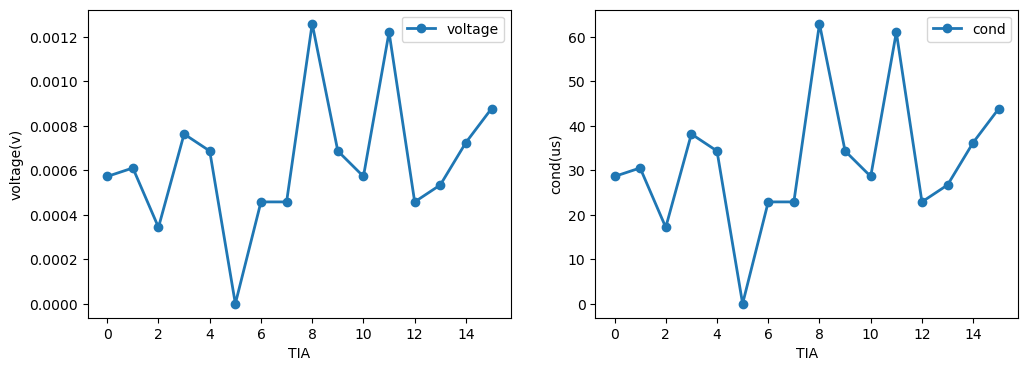

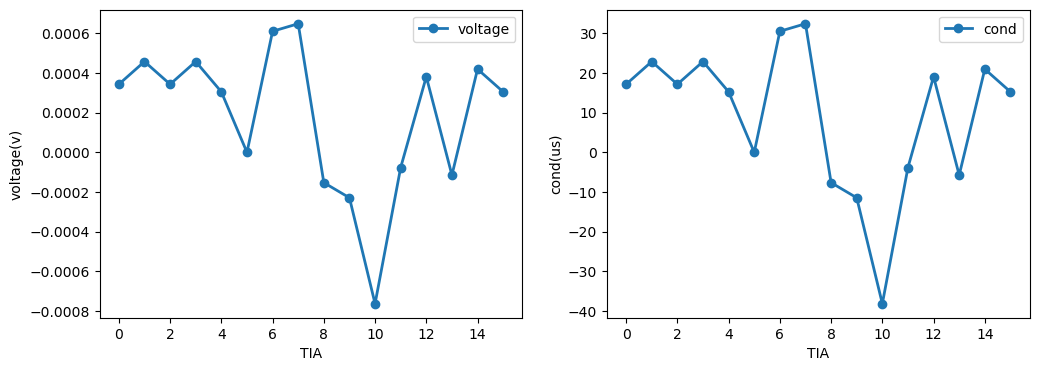

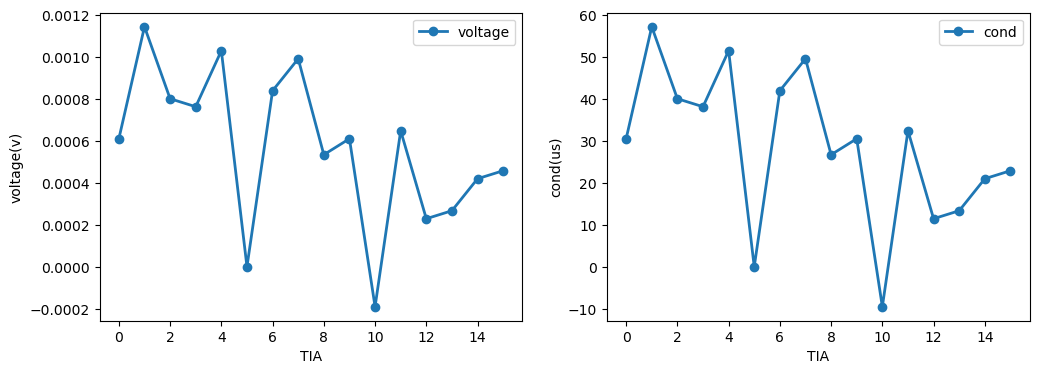

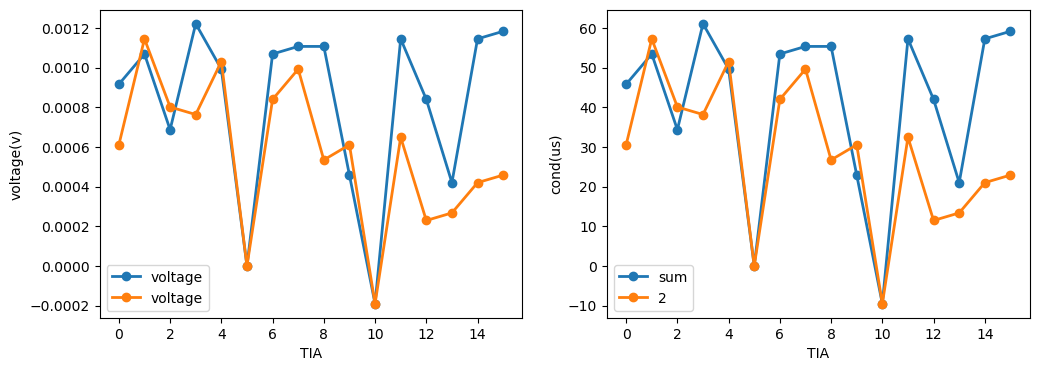

[ 0.00091556  0.00106815  0.00068667  0.00122074  0.00099185  0.
  0.00106815  0.0011063   0.0011063   0.00045778 -0.00019074  0.00114444
  0.00083926  0.00041963  0.00114444  0.00118259]
[ 0.00061037  0.00114444  0.00080111  0.00076296  0.00103     0.
  0.00083926  0.00099185  0.00053407  0.00061037 -0.00019074  0.00064852
  0.00022889  0.00026704  0.00041963  0.00045778]


In [367]:
res_sub = [(cond_base-cond,voltage_base-voltage) for cond,voltage in res]
for cond,voltage in res_sub[:3]:
    voltage[5]=0
    cond[5]=0
    # voltage[6]=0
    # cond[6]=0
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(voltage,marker='o', linestyle='-', linewidth=2,label="voltage")
    plt.ylabel("voltage(v)")
    plt.xlabel("TIA")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(cond,marker='o', linestyle='-', linewidth=2,label="cond")
    plt.ylabel("cond(us)")
    plt.xlabel("TIA")

    plt.legend()
    plt.show()


plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(res_sub[0][1]+res_sub[1][1],marker='o', linestyle='-', linewidth=2,label="voltage")
plt.plot(res_sub[2][1],marker='o', linestyle='-', linewidth=2,label="voltage")
plt.ylabel("voltage(v)")
plt.xlabel("TIA")
plt.legend()

plt.subplot(1,2,2)
plt.plot(res_sub[0][0]+res_sub[1][0],marker='o', linestyle='-', linewidth=2,label="sum")
plt.plot(res_sub[2][0],marker='o', linestyle='-', linewidth=2,label="2")
plt.ylabel("cond(us)")
plt.xlabel("TIA")

plt.legend()
plt.show()

print(res_sub[0][1]+res_sub[1][1])
print(res_sub[2][1])

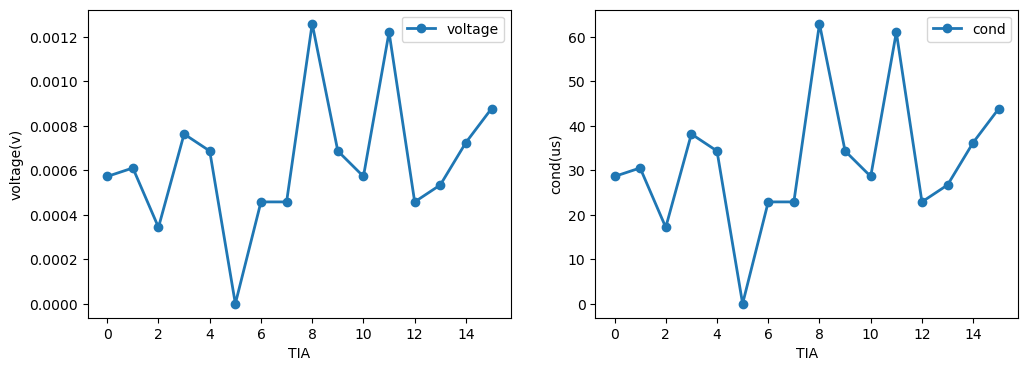

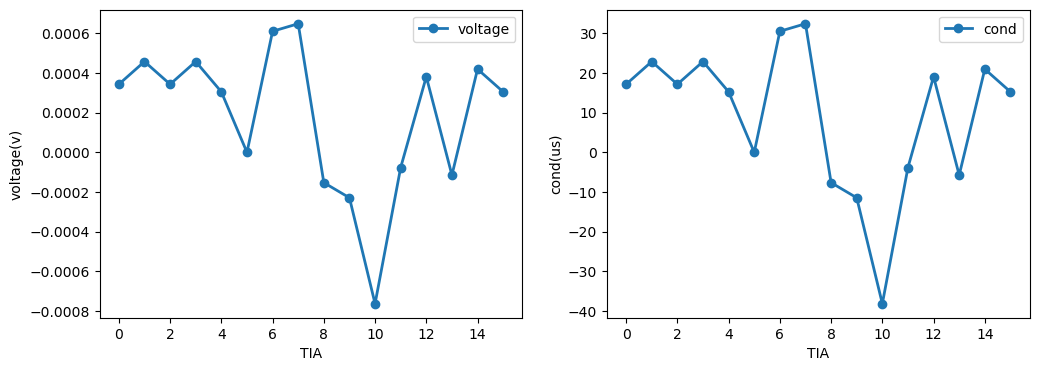

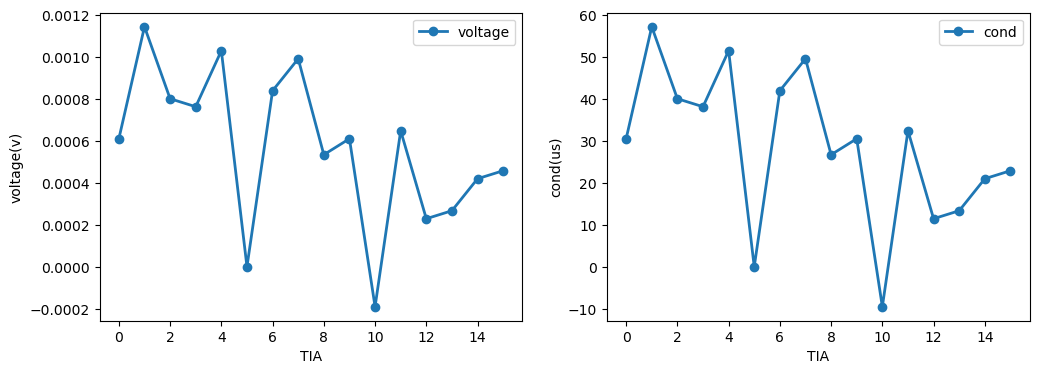

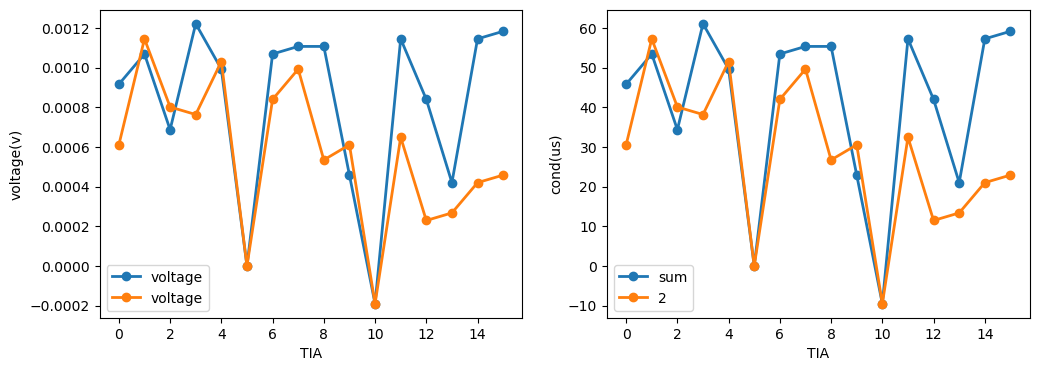

[ 0.00091556  0.00106815  0.00068667  0.00122074  0.00099185  0.
  0.00106815  0.0011063   0.0011063   0.00045778 -0.00019074  0.00114444
  0.00083926  0.00041963  0.00114444  0.00118259]
[ 0.00061037  0.00114444  0.00080111  0.00076296  0.00103     0.
  0.00083926  0.00099185  0.00053407  0.00061037 -0.00019074  0.00064852
  0.00022889  0.00026704  0.00041963  0.00045778]


In [368]:
res_sub = [(cond_base-cond,voltage_base-voltage) for cond,voltage in res]
for cond,voltage in res_sub[:3]:
    voltage[5]=0
    cond[5]=0
    # voltage[6]=0
    # cond[6]=0
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(voltage,marker='o', linestyle='-', linewidth=2,label="voltage")
    plt.ylabel("voltage(v)")
    plt.xlabel("TIA")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(cond,marker='o', linestyle='-', linewidth=2,label="cond")
    plt.ylabel("cond(us)")
    plt.xlabel("TIA")

    plt.legend()
    plt.show()


plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(res_sub[0][1]+res_sub[1][1],marker='o', linestyle='-', linewidth=2,label="voltage")
plt.plot(res_sub[2][1],marker='o', linestyle='-', linewidth=2,label="voltage")
plt.ylabel("voltage(v)")
plt.xlabel("TIA")
plt.legend()

plt.subplot(1,2,2)
plt.plot(res_sub[0][0]+res_sub[1][0],marker='o', linestyle='-', linewidth=2,label="sum")
plt.plot(res_sub[2][0],marker='o', linestyle='-', linewidth=2,label="2")
plt.ylabel("cond(us)")
plt.xlabel("TIA")

plt.legend()
plt.show()

print(res_sub[0][1]+res_sub[1][1])
print(res_sub[2][1])

### 2.4.2 减法读bank-反

In [296]:

chip.set_read_mode(row=True)                # 第二步设置，从行读，还是从列读
chip.set_dac_read_V(0.1)                    # 第三步设置读写电压
chip.set_tia_gain(3)                        # 第四步设置，TIA增益

In [297]:
chip.set_cim_reset()
chip.set_bank_latch([i for i in range(8)],row=True,value=0xFFFF_FFFF)
chip.set_bank_latch([i for i in range(8)],row=False,value=0xFFFF_FFFF)

In [298]:
print(chip.get_setting_info())

操作模式：read	器件：ECRAM	读电压：0.1v	从行\列给电压：行	TIA增益：3


In [299]:
chip.generate_read_pulse()
cond_base,voltage_base = chip.get_tia_out([k for k in range(16)])

res = []
read_row=[
    [3],
    [7],
    [3,7],

    [0],
    [4],
    [0,4]
]
for num in read_row:
    chip.set_bank_latch(num,row=True,value=0)
    # for i in num:
    #     bank,_ = chip.numToBank_Index(i[0])
    #     _,index = chip.get_data(i)
    #     print(bank,bin(index))
    #     chip.set_bank_latch([bank],row=True,value=0xFFFF_FFFF^(index))

    chip.generate_read_pulse()
    tmp = chip.get_tia_out([k for k in range(16)])
    res.append(tmp)


    chip.set_bank_latch(num,row=True,value=0xFFFF_FFFF)
    # for i in num:
    #     bank,_ = chip.numToBank_Index(i[0])
    #     _,index = chip.get_data(i)
    #     chip.set_bank_latch([bank],row=True,value=0xFFFF_FFFF)

In [ ]:
print(voltage_base)

for cond,voltage in res:
    print()
    print(voltage)

In [300]:
chip.generate_read_pulse()
cond_base,voltage_base = chip.get_tia_out([k for k in range(16)])

res = []
read_row=[
    [3],
    [7],
    [3,7],

    [0],
    [4],
    [0,4]
]
for num in read_row:
    chip.set_bank_latch(num,row=True,value=0)
    # for i in num:
    #     bank,_ = chip.numToBank_Index(i[0])
    #     _,index = chip.get_data(i)
    #     print(bank,bin(index))
    #     chip.set_bank_latch([bank],row=True,value=0xFFFF_FFFF^(index))

    chip.generate_read_pulse()
    tmp = chip.get_tia_out([k for k in range(16)])
    res.append(tmp)


    chip.set_bank_latch(num,row=True,value=0xFFFF_FFFF)
    # for i in num:
    #     bank,_ = chip.numToBank_Index(i[0])
    #     _,index = chip.get_data(i)
    #     chip.set_bank_latch([bank],row=True,value=0xFFFF_FFFF)

[0.4729606  0.41833247 0.48306986 0.40208136 0.44961394 0.35637989
 0.42703024 0.48383282 0.47322764 0.46514023 0.43229469 0.41829432
 0.41627247 0.39975433 0.39094211 0.36866359]

[0.44682913 0.39571062 0.45716727 0.38033692 0.42470321 0.33940397
 0.40448469 0.45812098 0.44179357 0.43511765 0.40597247 0.39395581
 0.39304025 0.37724693 0.36927396 0.34817804]

[0.44385357 0.39300211 0.45342875 0.37766655 0.42115543 0.33852657
 0.40173803 0.45392468 0.44465468 0.43595691 0.40475173 0.39120914
 0.38979766 0.37236396 0.36297952 0.34020508]

[0.41707358 0.36957915 0.42619098 0.35508286 0.3952147  0.32086398
 0.37842952 0.42764061 0.41142766 0.40498062 0.377781   0.3655736
 0.36564989 0.34920804 0.34089175 0.31903287]

[0.43183691 0.38529618 0.44629505 0.3735847  0.41570025 0.3367336
 0.39723655 0.44991913 0.44045839 0.43259987 0.40200507 0.38872951
 0.38762322 0.37179174 0.36385693 0.34295175]

[0.45514542 0.40311136 0.46525468 0.38918729 0.43176061 0.34726249
 0.40898618 0.46189764 0.45712

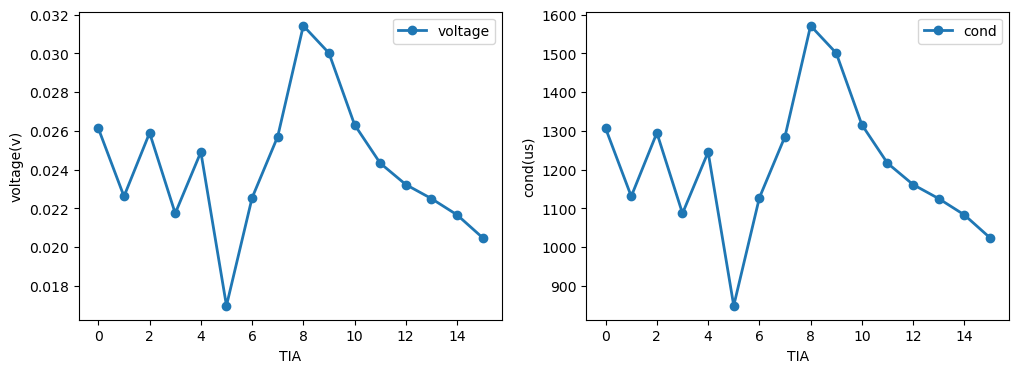

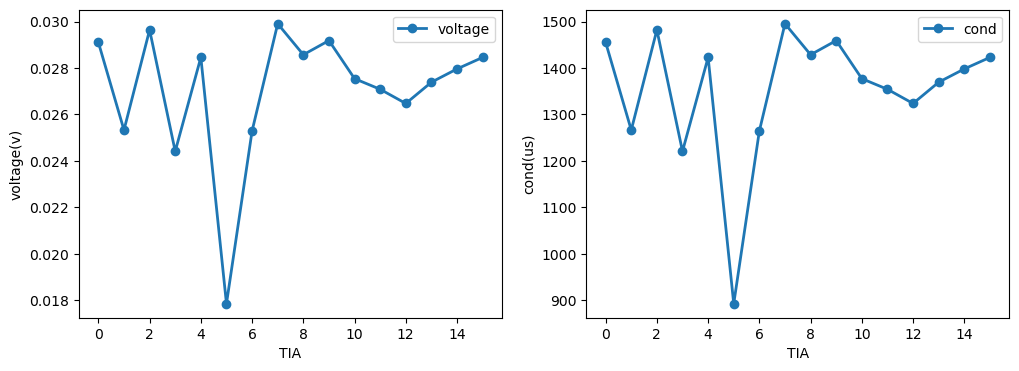

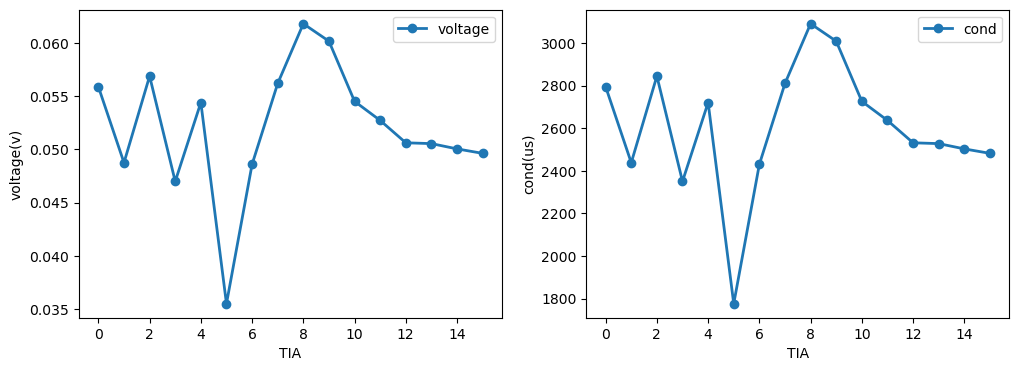

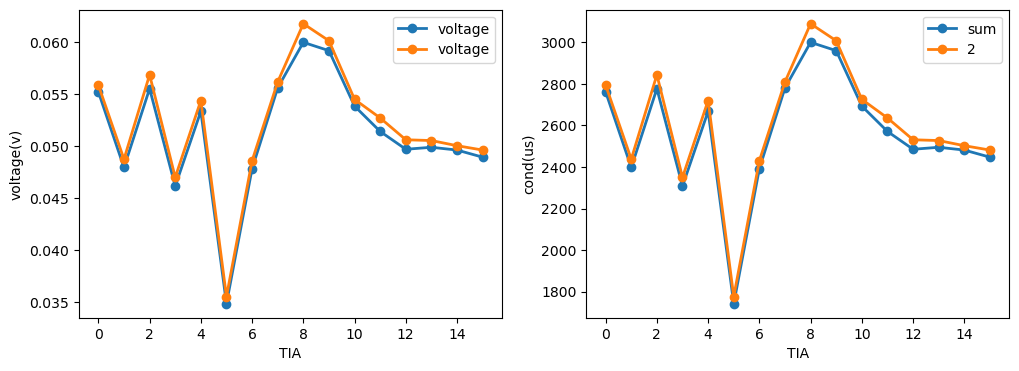

[0.0552385  0.04795221 0.05554369 0.04615925 0.05336924 0.03482925
 0.04783776 0.05561998 0.06000702 0.05920591 0.05386517 0.05142369
 0.04970702 0.04989776 0.04963073 0.04894406]
[0.05588702 0.04875332 0.05687887 0.0469985  0.05439924 0.03551592
 0.04860073 0.05619221 0.06179998 0.06015961 0.05451369 0.05272073
 0.05062258 0.05054628 0.05005036 0.04963073]


In [301]:
res_sub = [(cond_base-cond,voltage_base-voltage) for cond,voltage in res]
for cond,voltage in res_sub[:3]:
    # voltage[5]=0
    # cond[5]=0
    # voltage[6]=0
    # cond[6]=0
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(voltage,marker='o', linestyle='-', linewidth=2,label="voltage")
    plt.ylabel("voltage(v)")
    plt.xlabel("TIA")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(cond,marker='o', linestyle='-', linewidth=2,label="cond")
    plt.ylabel("cond(us)")
    plt.xlabel("TIA")

    plt.legend()
    plt.show()


plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(res_sub[0][1]+res_sub[1][1],marker='o', linestyle='-', linewidth=2,label="voltage")
plt.plot(res_sub[2][1],marker='o', linestyle='-', linewidth=2,label="voltage")
plt.ylabel("voltage(v)")
plt.xlabel("TIA")
plt.legend()

plt.subplot(1,2,2)
plt.plot(res_sub[0][0]+res_sub[1][0],marker='o', linestyle='-', linewidth=2,label="sum")
plt.plot(res_sub[2][0],marker='o', linestyle='-', linewidth=2,label="2")
plt.ylabel("cond(us)")
plt.xlabel("TIA")

plt.legend()
plt.show()

print(res_sub[0][1]+res_sub[1][1])
print(res_sub[2][1])

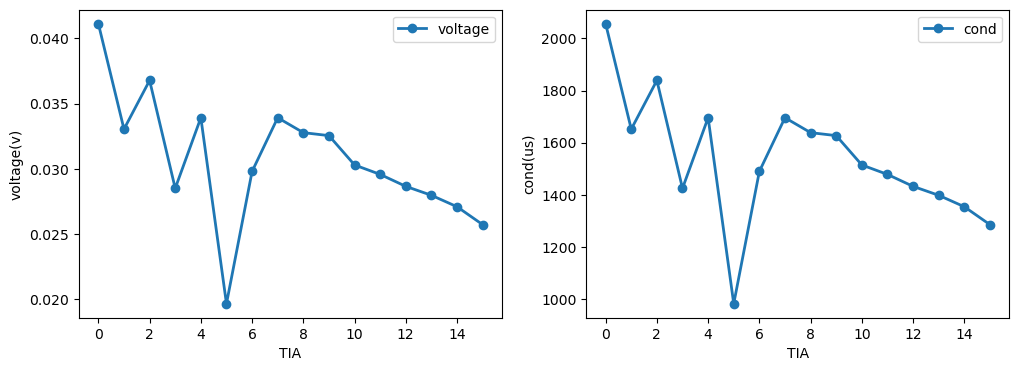

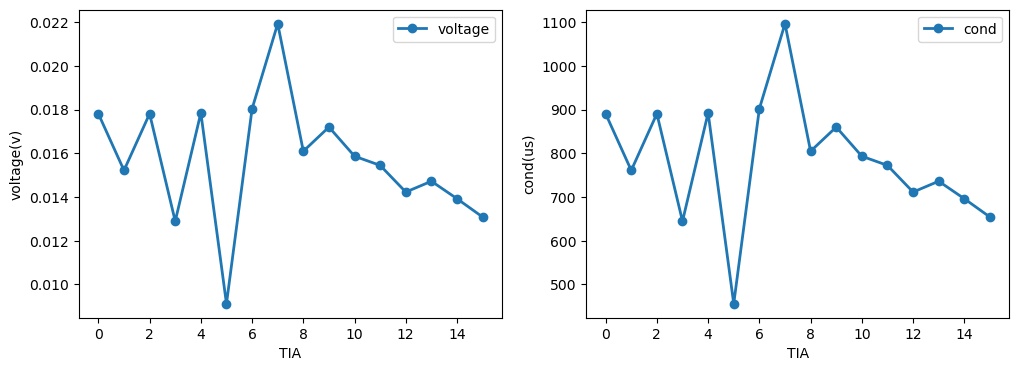

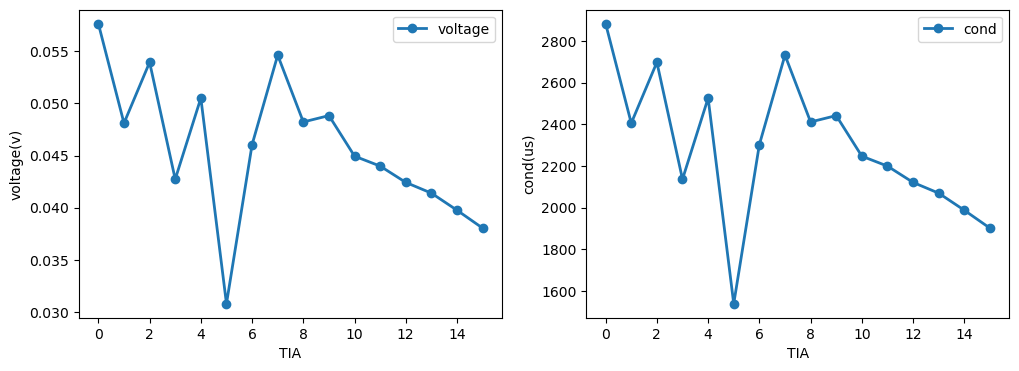

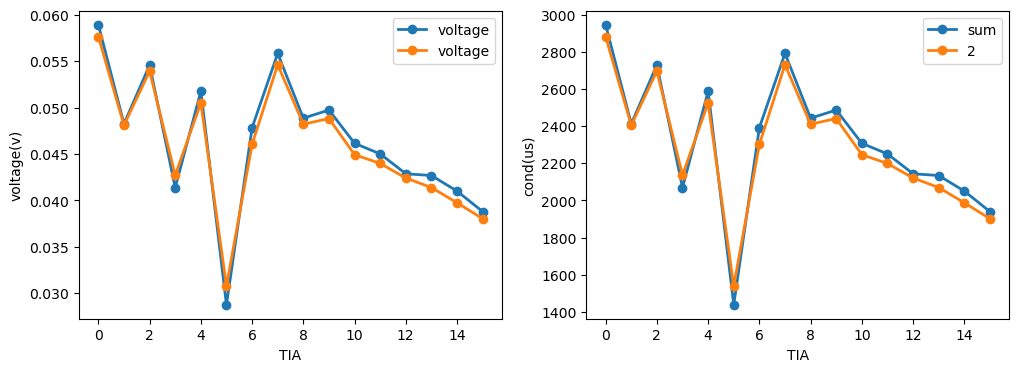

[0.0552385  0.04795221 0.05554369 0.04615925 0.05336924 0.03482925
 0.04783776 0.05561998 0.06000702 0.05920591 0.05386517 0.05142369
 0.04970702 0.04989776 0.04963073 0.04894406]
[0.05588702 0.04875332 0.05687887 0.0469985  0.05439924 0.03551592
 0.04860073 0.05619221 0.06179998 0.06015961 0.05451369 0.05272073
 0.05062258 0.05054628 0.05005036 0.04963073]


In [302]:
res_sub = [(cond_base-cond,voltage_base-voltage) for cond,voltage in res]
for cond,voltage in res_sub[3:]:
    # voltage[5]=0
    # cond[5]=0
    # voltage[6]=0
    # cond[6]=0
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(voltage,marker='o', linestyle='-', linewidth=2,label="voltage")
    plt.ylabel("voltage(v)")
    plt.xlabel("TIA")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(cond,marker='o', linestyle='-', linewidth=2,label="cond")
    plt.ylabel("cond(us)")
    plt.xlabel("TIA")

    plt.legend()
    plt.show()


plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(res_sub[3][1]+res_sub[4][1],marker='o', linestyle='-', linewidth=2,label="voltage")
plt.plot(res_sub[5][1],marker='o', linestyle='-', linewidth=2,label="voltage")
plt.ylabel("voltage(v)")
plt.xlabel("TIA")
plt.legend()

plt.subplot(1,2,2)
plt.plot(res_sub[3][0]+res_sub[4][0],marker='o', linestyle='-', linewidth=2,label="sum")
plt.plot(res_sub[5][0],marker='o', linestyle='-', linewidth=2,label="2")
plt.ylabel("cond(us)")
plt.xlabel("TIA")

plt.legend()
plt.show()

print(res_sub[0][1]+res_sub[1][1])
print(res_sub[2][1])

### 2.4.3 正读

In [184]:

chip.set_read(row=True,v=0.1,gain=3,tg_v=5)

In [185]:
print(chip.get_setting_info())

操作模式：read	器件：ReRAM	读电压：0.2v	从行\列给电压：行	TIA增益：3


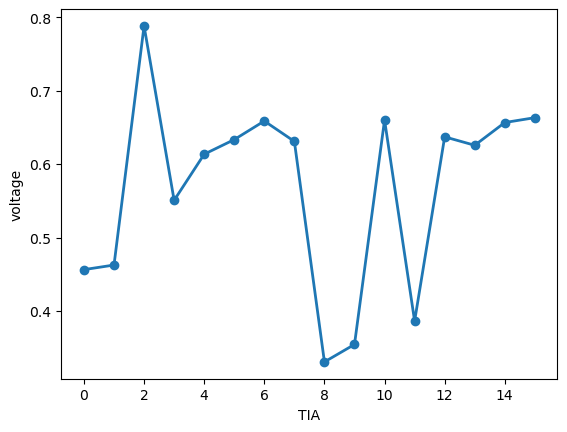

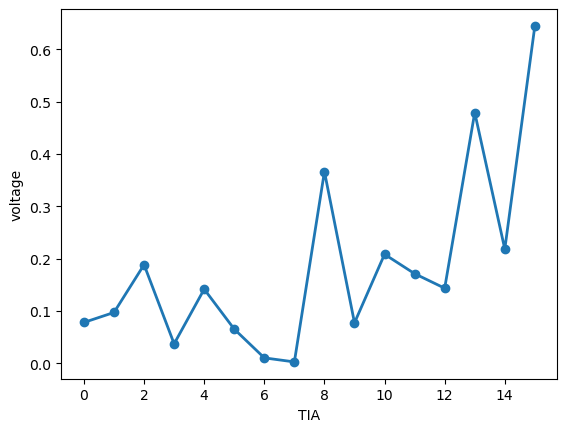

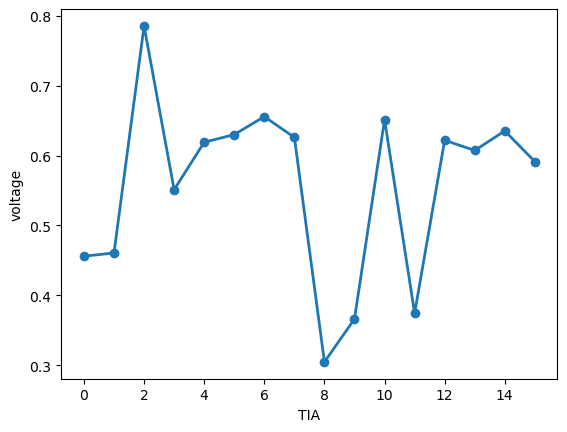

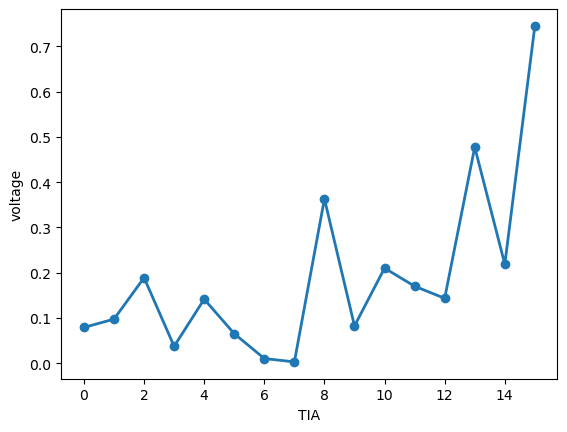

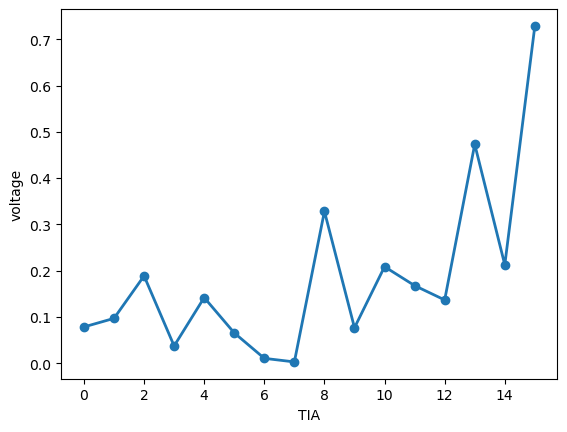

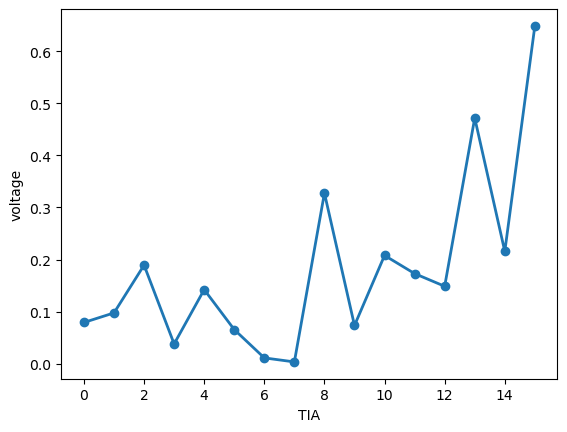

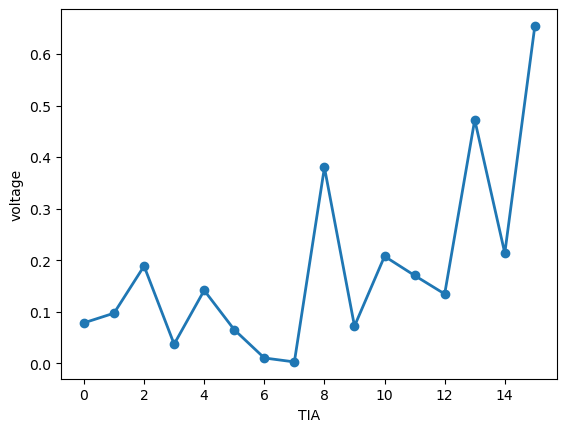

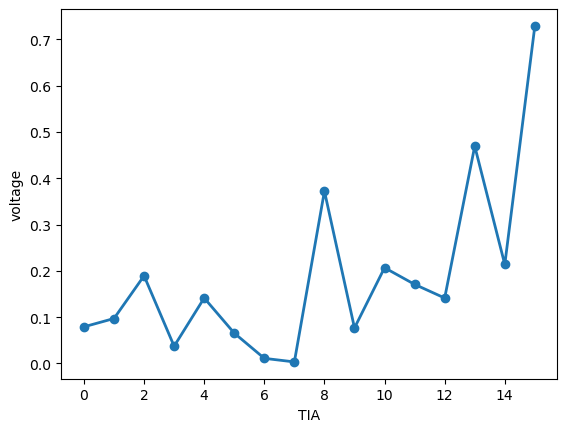

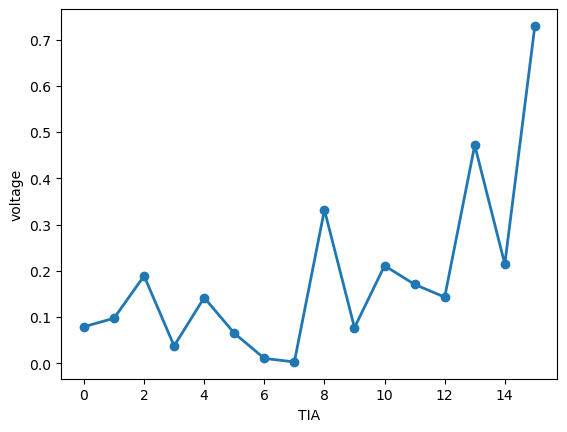

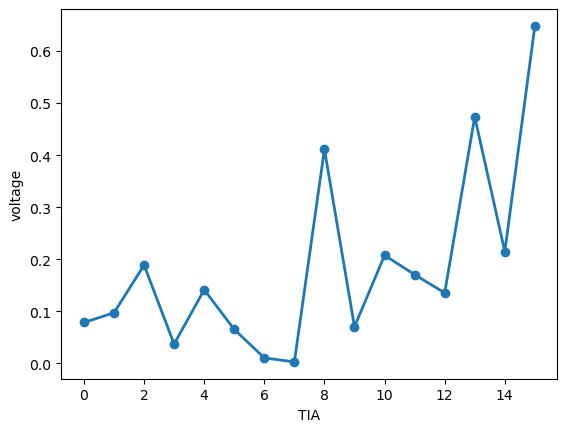

In [186]:
for i in range(10):
    chip.set_cim_reset()
    chip.set_bank_latch([i for i in range(8)],row=True,value=0xFFFF_FFFF)
    chip.set_bank_latch([i for i in range(8)],row=False,value=0xFFFF_FFFF)

    chip.generate_read_pulse()
    cond_base,voltage_base = chip.get_tia_out([k for k in range(16)])


    plt.figure()
    plt.plot(voltage_base, marker='o', linestyle='-', linewidth=2)
    plt.ylabel("voltage")
    plt.xlabel("TIA")
    plt.show()

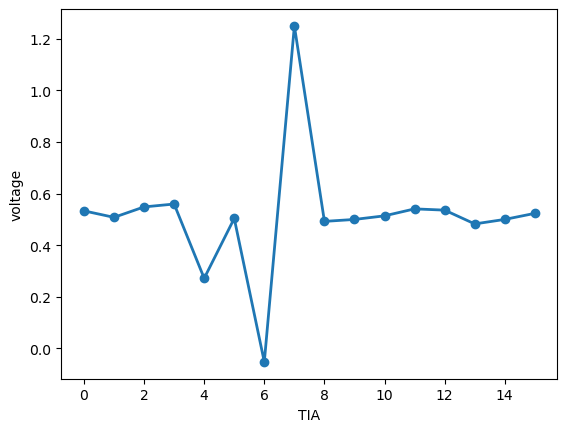

In [49]:
chip.set_cim_reset()
chip.set_bank_latch([i for i in range(8)],row=True,value=0)
chip.set_bank_latch([i for i in range(8)],row=False,value=0)

chip.generate_read_pulse()
cond_base,voltage_base = chip.get_tia_out([k for k in range(16)])


plt.figure()
plt.plot(voltage_base, marker='o', linestyle='-', linewidth=2)
plt.ylabel("voltage")
plt.xlabel("TIA")
# plt.legend()
plt.show()

In [ ]:

chip.set_read_mode(row=True)                # 第二步设置，从行读，还是从列读
chip.set_dac_read_V(0.1,tg_v=5)             # 第三步设置读写电压
chip.set_tia_gain(3)                        # 第四步设置，TIA增益

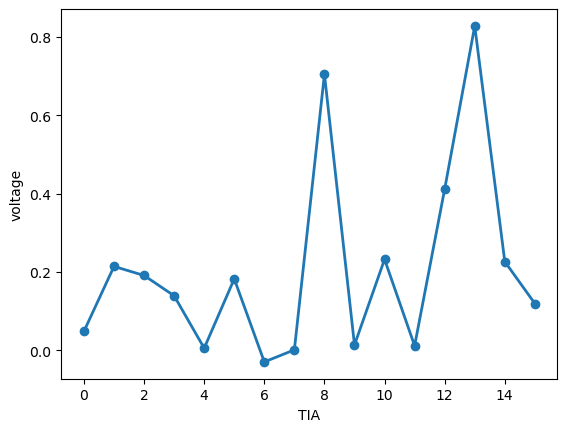

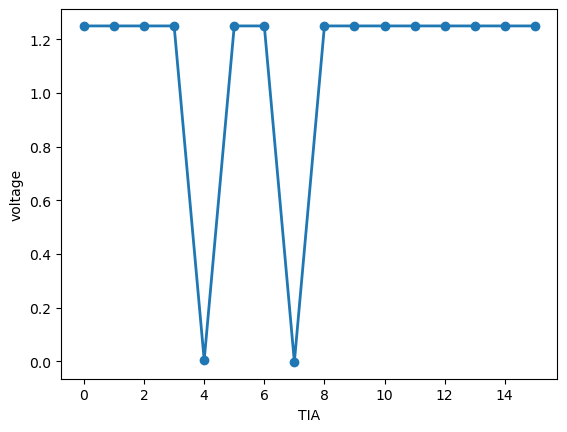

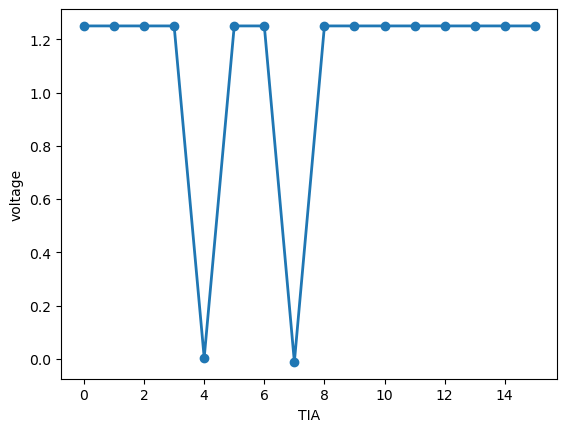

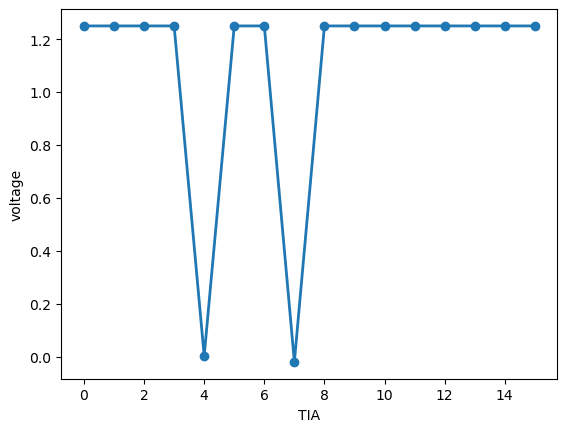

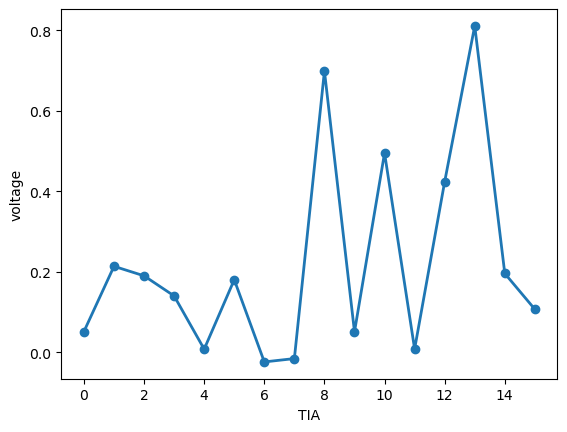

KeyboardInterrupt: 

In [35]:
adc.set_gain(3)
for i in range(8):
    chip.set_cim_reset()
    chip.set_bank_latch([k for k in range(8)],row=True,value=0xFFFF_FFFF)
    chip.set_bank_latch([i],row=False,value=0xFFFF_FFFF)
    chip.generate_read_pulse()
    tia_cond,tia_v=adc.get_out([k for k in range(16)],0)

    plt.figure()
    plt.plot(tia_v, marker='o', linestyle='-', linewidth=2)
    plt.ylabel("voltage")
    plt.xlabel("TIA")
    plt.show()

In [74]:
ps.debug = False
ps.delay = 0.5

In [77]:

chip.set_read_mode(row=True)                # 第二步设置，从行读，还是从列读
chip.set_tia_gain(3)                        # 第四步设置，TIA增益
chip.set_dac_read_V(0,tg_v=0)

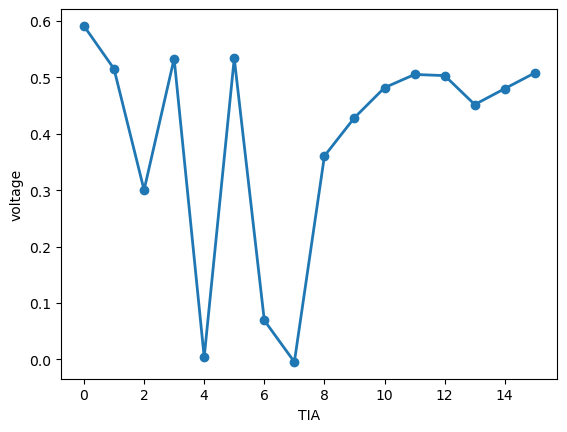

In [79]:


chip.set_cim_reset()
# chip.set_latch([[128]],row=True,value=None)
# chip.set_latch([[128]],row=False,value=None)


chip.generate_read_pulse()
tia_cond,tia_v=chip.get_tia_out([k for k in range(16)])

plt.figure()
plt.plot(tia_v, marker='o', linestyle='-', linewidth=2)
plt.ylabel("voltage")
plt.xlabel("TIA")
plt.show()

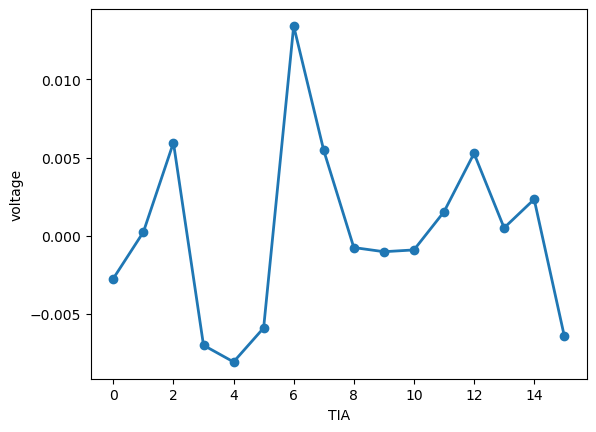

KeyboardInterrupt: 

In [188]:
for i in range(3):
    chip.set_read_mode(row=True)                # 第二步设置，从行读，还是从列读
    chip.set_tia_gain(3)                        # 第四步设置，TIA增益

    chip.set_cim_reset()
    chip.set_latch([[128]],row=True,value=None)
    chip.set_latch([[128]],row=False,value=None)

    chip.set_dac_read_V(0.1,tg_v=5)
    chip.generate_read_pulse()
    tia_cond,tia_v=chip.get_tia_out([k for k in range(16)])

    plt.figure()
    plt.plot(tia_v, marker='o', linestyle='-', linewidth=2)
    plt.ylabel("voltage")
    plt.xlabel("TIA")
    plt.show()


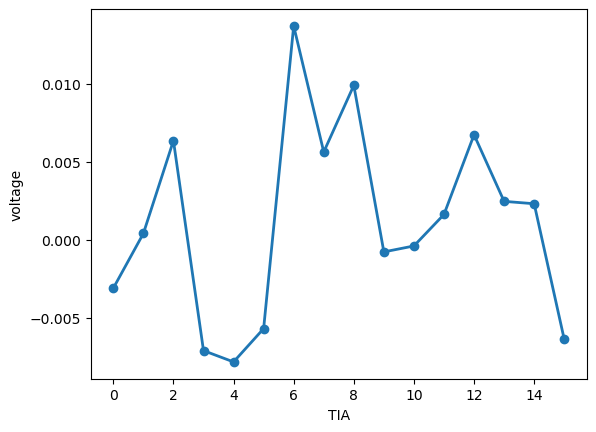

In [228]:

chip.set_read_mode(row=True)                # 第二步设置，从行读，还是从列读
chip.set_tia_gain(3)                        # 第四步设置，TIA增益
chip.set_cim_reset()
chip.set_latch([[6]],row=True,value=None)
chip.set_latch([[0]],row=False,value=None)


chip.set_dac_read_V(5,tg_v=2.0)
pkts=Packet()
pkts.append_cmdlist([
    CMD(PULSE_CYC,command_data=CmdData(0)),                                             # 翻转
    CMD(FAST_COMMAND_1,command_data=CmdData(FAST_COMMAND1_CONF.cfg_col_pulse)),         # cfg_col_pulse，配置列为常1
    CMD(PULSE_CYC,command_data=CmdData(102400000)),                                              # 设置脉宽
    CMD(FAST_COMMAND_1,command_data=CmdData(FAST_COMMAND1_CONF.cfg_row_pulse)),             # cfg_row_pulse, 给写脉冲

    # CMD(PULSE_CYC,command_data=CmdData(0)),                                             # 翻转
    # CMD(FAST_COMMAND_1,command_data=CmdData(FAST_COMMAND1_CONF.cfg_col_pulse)),         # cfg_col_pulse，读完后，把列电压翻转为0
],mode=1)
ps.send_packets(pkts)


# 读器件
chip.set_dac_read_V(0.1,tg_v=5)
chip.generate_read_pulse()
tia_cond,tia_v=chip.get_tia_out([k for k in range(16)])

plt.figure()
plt.plot(tia_v, marker='o', linestyle='-', linewidth=2)
plt.ylabel("voltage")
plt.xlabel("TIA")
plt.show()

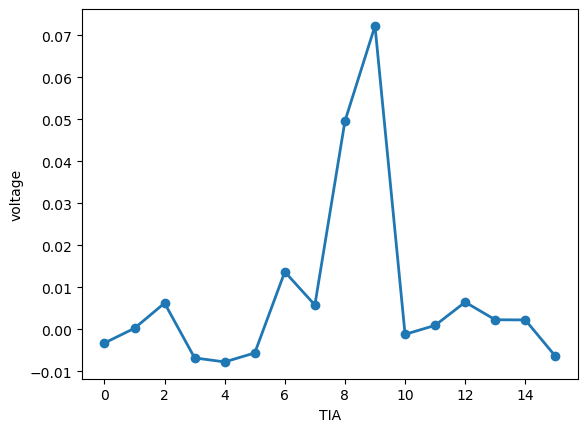

In [229]:

chip.set_read_mode(row=True)                # 第二步设置，从行读，还是从列读
chip.set_tia_gain(3)                        # 第四步设置，TIA增益
chip.set_cim_reset()
chip.set_latch([[6]],row=True,value=None)
chip.set_latch([[0]],row=False,value=None)

chip.set_dac_read_V(0.1,tg_v=5)
chip.generate_read_pulse()
tia_cond,tia_v=chip.get_tia_out([k for k in range(16)])

plt.figure()
plt.plot(tia_v, marker='o', linestyle='-', linewidth=2)
plt.ylabel("voltage")
plt.xlabel("TIA")
plt.show()

In [237]:

chip.set_read_mode(row=False)                # 第二步设置，从行读，还是从列读
chip.set_tia_gain(3)                        # 第四步设置，TIA增益

In [238]:

v = 3
chip.dac.set_voltage(0,dac_num=0,dac_channel=0)           #
chip.dac.set_voltage(0,dac_num=0,dac_channel=1)           #
chip.dac.set_voltage(0,dac_num=0,dac_channel=2)           #
chip.dac.set_voltage(0,dac_num=0,dac_channel=3)           #

chip.dac.set_voltage(0,dac_num=0,dac_channel=4)           #
chip.dac.set_voltage(0,dac_num=0,dac_channel=5)           #
chip.dac.set_voltage(1.5,dac_num=0,dac_channel=6)           # TG
chip.dac.set_voltage(0,dac_num=0,dac_channel=7)           #

chip.dac.set_voltage(v,dac_num=1,dac_channel=0)           # ROW_Va
chip.dac.set_voltage(0,dac_num=1,dac_channel=1)           #    
chip.dac.set_voltage(v,dac_num=1,dac_channel=2)           # COL_Va
chip.dac.set_voltage(0,dac_num=1,dac_channel=3)           #

In [239]:
# chip.set_dac_read_V(5,tg_v=2.0)
chip.set_cim_reset()
chip.set_latch([[1]],row=True,value=None)
chip.set_latch([[0]],row=False,value=None)

pkts=Packet()
pkts.append_cmdlist([
    CMD(PULSE_CYC,command_data=CmdData(0)),                                             # 翻转
    CMD(FAST_COMMAND_1,command_data=CmdData(FAST_COMMAND1_CONF.cfg_row_pulse)),         # cfg_col_pulse，配置列为常1
    CMD(PULSE_CYC,command_data=CmdData(10240)),                                              # 设置脉宽
    CMD(FAST_COMMAND_1,command_data=CmdData(FAST_COMMAND1_CONF.cfg_col_pulse)),             # cfg_row_pulse, 给写脉冲
],mode=1)
ps.send_packets(pkts)


Text(0.5, 0, 'TIA')

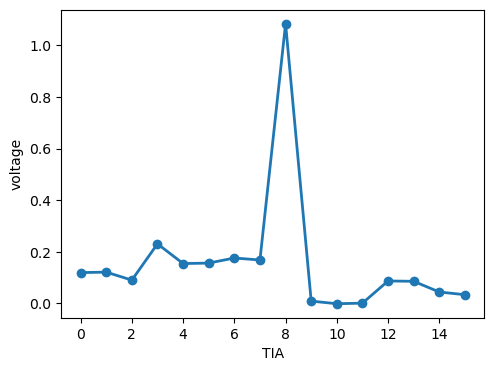

In [240]:

chip.set_read_mode(row=True)                # 第二步设置，从行读，还是从列读
chip.set_tia_gain(2)                        # 第四步设置，TIA增益
chip.set_dac_read_V(0.1,tg_v=5)

chip.set_cim_reset()                        # reset操作
chip.set_latch([[1]],row=True,value=None)
chip.set_latch([[0]],row=False,value=None)

chip.generate_read_pulse()
tia_cond,tia_v=chip.get_tia_out([k for k in range(16)])

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(tia_v, marker='o', linestyle='-', linewidth=2)
plt.ylabel("voltage")
plt.xlabel("TIA")

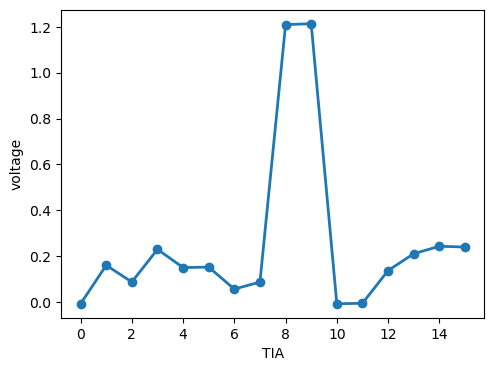

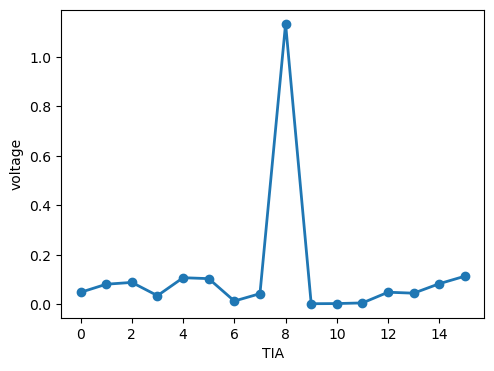

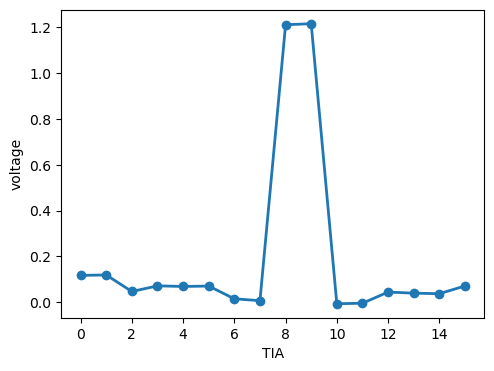

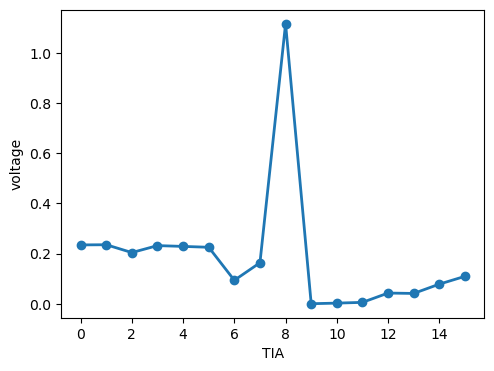

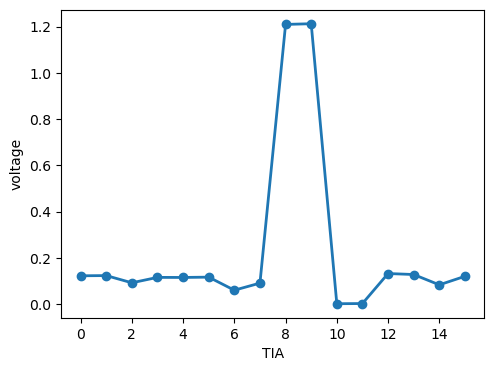

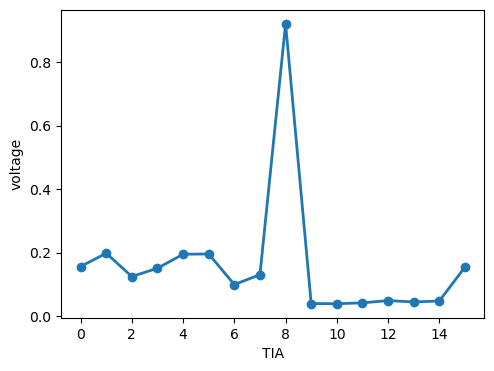

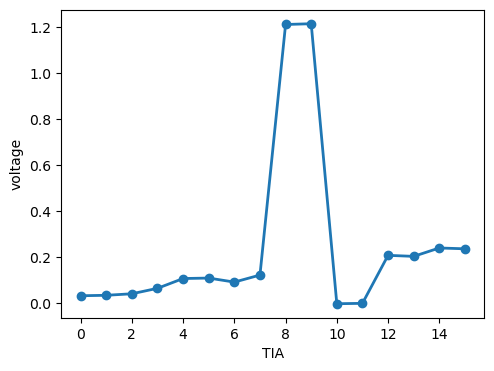

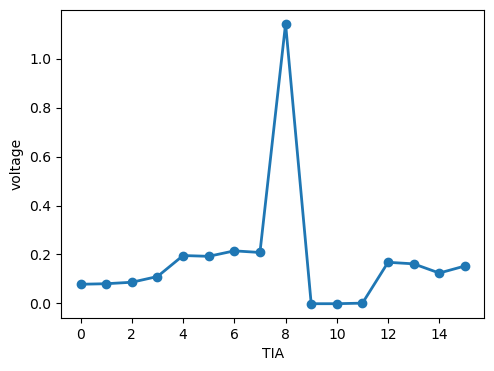

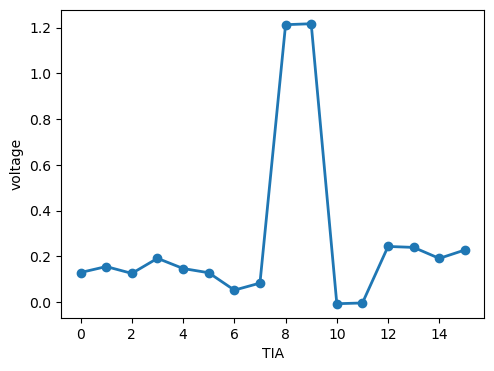

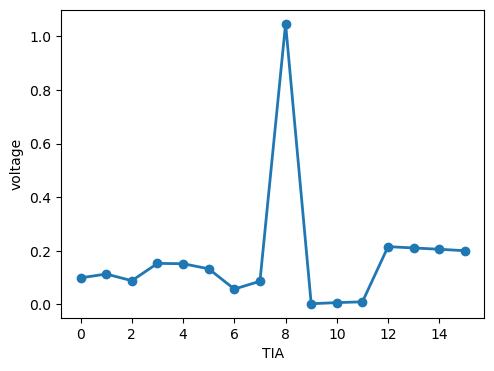

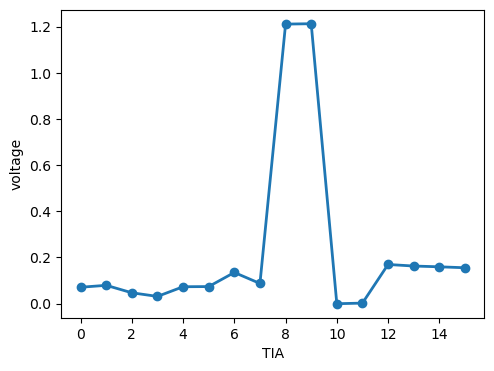

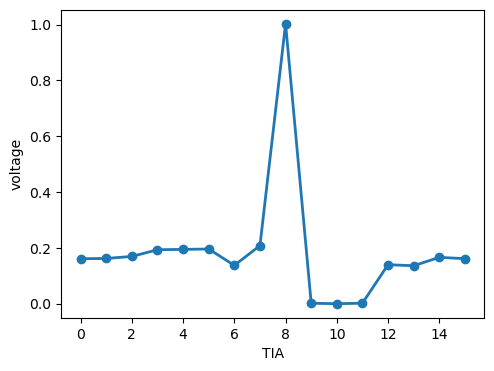

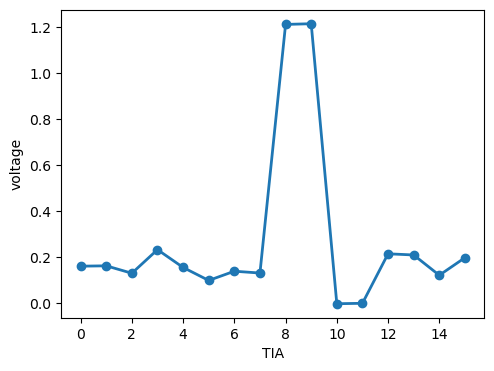

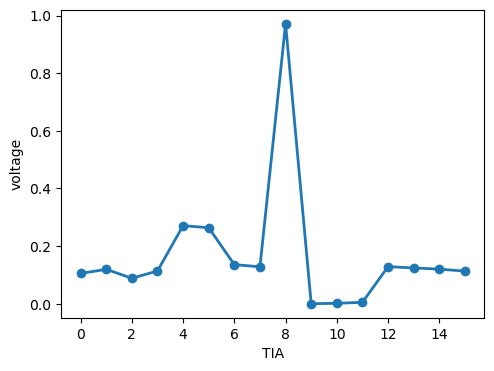

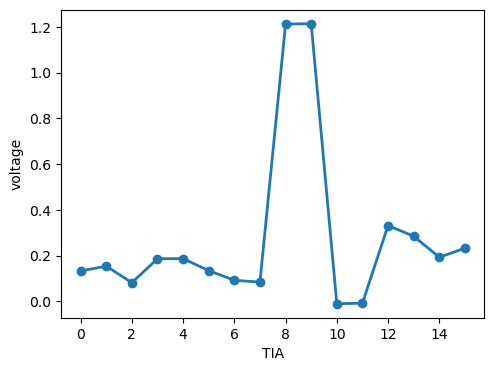

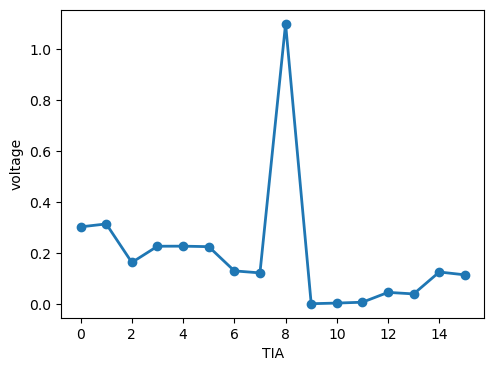

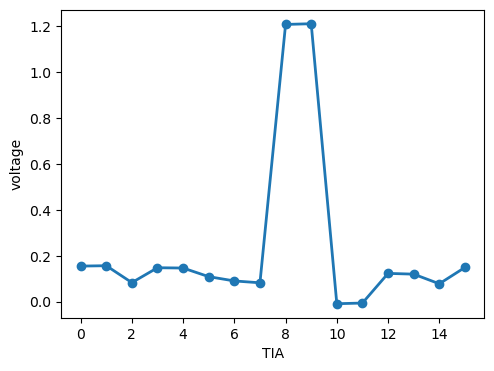

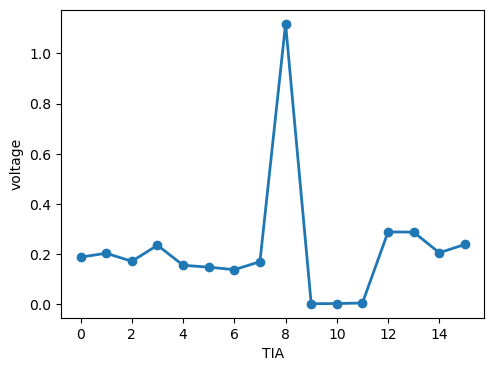

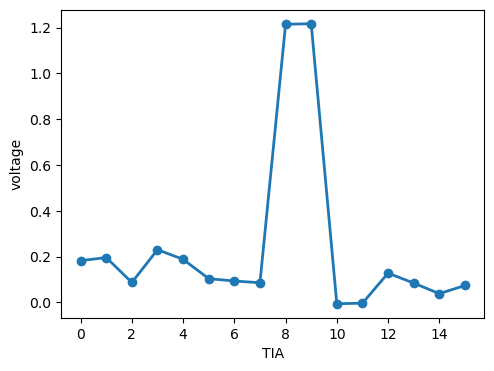

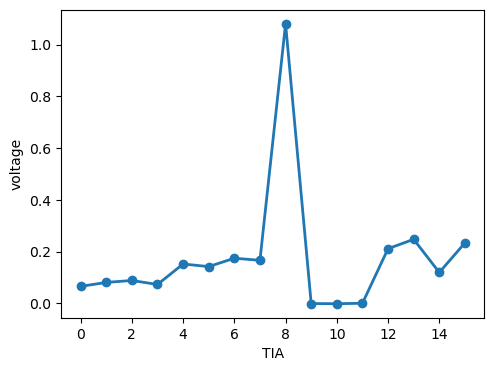

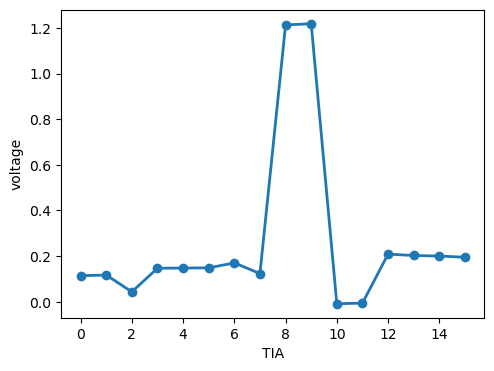

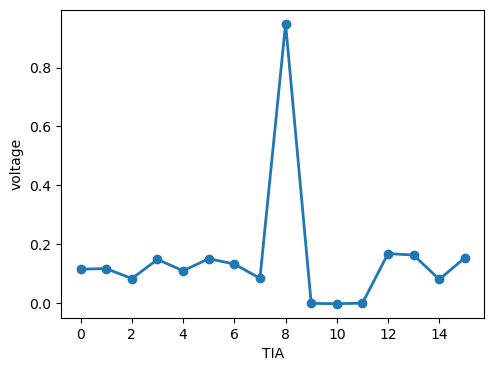

KeyboardInterrupt: 

In [231]:
chip.set_read_mode(row=True)                # 第二步设置，从行读，还是从列读
chip.set_tia_gain(2)                        # 第四步设置，TIA增益
chip.set_dac_read_V(0.1,tg_v=5)

for i in range(32):
    chip.set_cim_reset()                        # reset操作
    chip.set_latch([[i]],row=True,value=None)
    chip.set_latch([[0]],row=False,value=None)

    chip.generate_read_pulse()
    tia_cond,tia_v=chip.get_tia_out([k for k in range(16)])

    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(tia_v, marker='o', linestyle='-', linewidth=2)
    plt.ylabel("voltage")
    plt.xlabel("TIA")


    # plt.subplot(1,2,2)
    # plt.plot(tia_cond, marker='o', linestyle='-', linewidth=2)
    # plt.ylabel("cond")
    # plt.xlabel("TIA")

    plt.show()

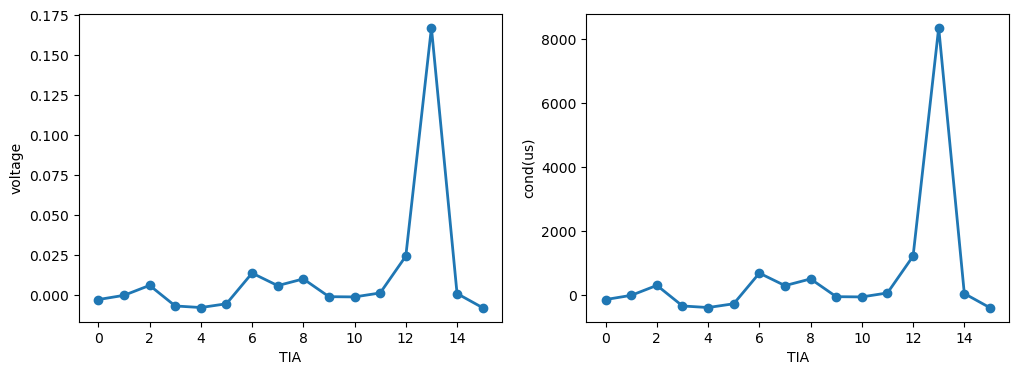

In [201]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(tia_v, marker='o', linestyle='-', linewidth=2)
plt.ylabel("voltage")
plt.xlabel("TIA")


plt.subplot(1,2,2)
plt.plot(tia_cond, marker='o', linestyle='-', linewidth=2)
plt.ylabel("cond(us)")
plt.xlabel("TIA")

plt.show()

In [9]:
chip.generate_read_pulse()
cond_base,voltage_base = chip.get_tia_out([k for k in range(16)])

res = []
read_row=[
    [[51]],
    [[53]],
    [[51,53]],

    [[163]],
    [[165]],
    [[163,165]]
]
for num in read_row:
    # chip.set_bank_latch(num,row=True,value=0)
    for i in num:
        bank,_ = chip.numToBank_Index(i[0])
        _,index = chip.get_data(i)
        print(bank,bin(index))
        chip.set_bank_latch([bank],row=True,value=0xFFFF_FFFF^(index))

    chip.generate_read_pulse()
    tmp = chip.get_tia_out([k for k in range(16)])
    res.append(tmp)


    # chip.set_bank_latch(num,row=True,value=0xFFFF_FFFF)
    for i in num:
        bank,_ = chip.numToBank_Index(i[0])
        _,index = chip.get_data(i)
        chip.set_bank_latch([bank],row=True,value=0xFFFF_FFFF)

4 0b10000000000000000000000000
4 0b100000000000000000000000000
4 0b110000000000000000000000000
6 0b100000000000000000
6 0b1000000000000000000
6 0b1100000000000000000


In [12]:
print(voltage_base)

for cond,voltage in res:
    print()
    print(voltage)

[-0.00041963  0.00621815 -0.00106815  0.00938444  0.00377667 -0.00278481
 -0.02285073 -0.00553148  0.00606555 -0.00434889 -0.00125889  0.00339518
  0.00244148 -0.01480148  0.00637074  0.00373852]

[-0.00022889  0.00629444 -0.00091556  0.00949889  0.00385296 -0.00274667
 -0.02288888 -0.00545518  0.00614185 -0.0041963  -0.00103     0.00358592
  0.00236518 -0.01495407  0.00629444  0.00362407]

[-0.00068667  0.00587481 -0.00133518  0.00900296  0.00396741 -0.00259407
 -0.0225837  -0.00541704  0.00629444 -0.00415815 -0.00103     0.00362407
  0.00228889 -0.01495407  0.00618     0.00358592]

[-0.00053407  0.00595111 -0.00125889  0.00907926  0.00377667 -0.00282296
 -0.02277444 -0.00549333  0.00625629 -0.00415815 -0.00103     0.00358592
  0.00225074 -0.01506851  0.00618     0.00350963]

[-0.00038148  0.00621815 -0.00103     0.00938444  0.00400555 -0.00255593
 -0.02254555 -0.00530259  0.00629444 -0.00415815 -0.00099185  0.00362407
  0.00228889 -0.01491592  0.00618     0.00358592]

[-0.00022889  0

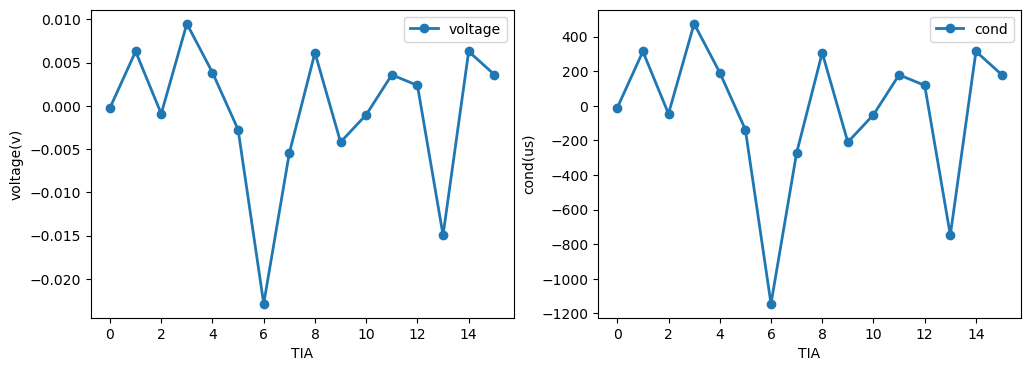

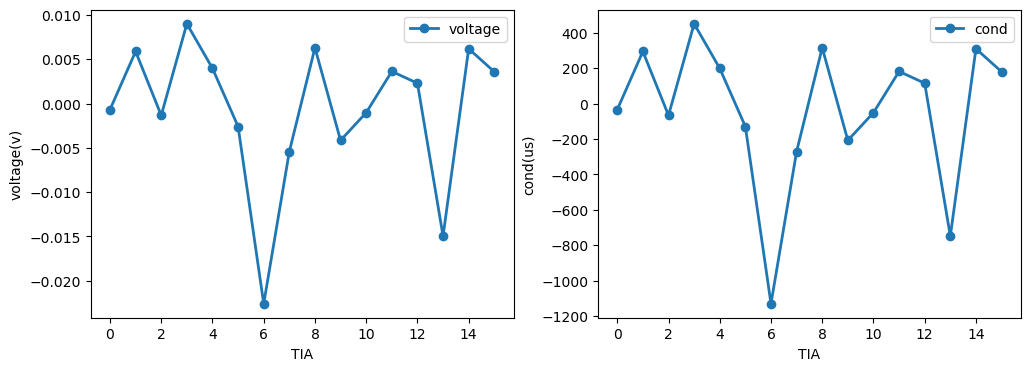

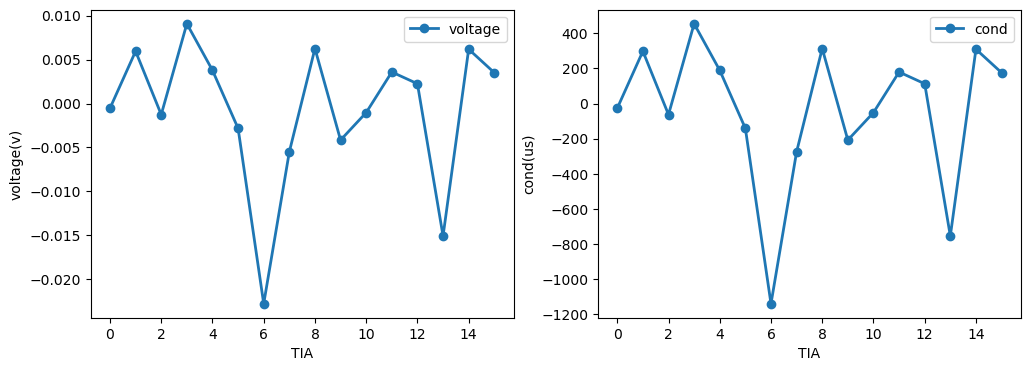

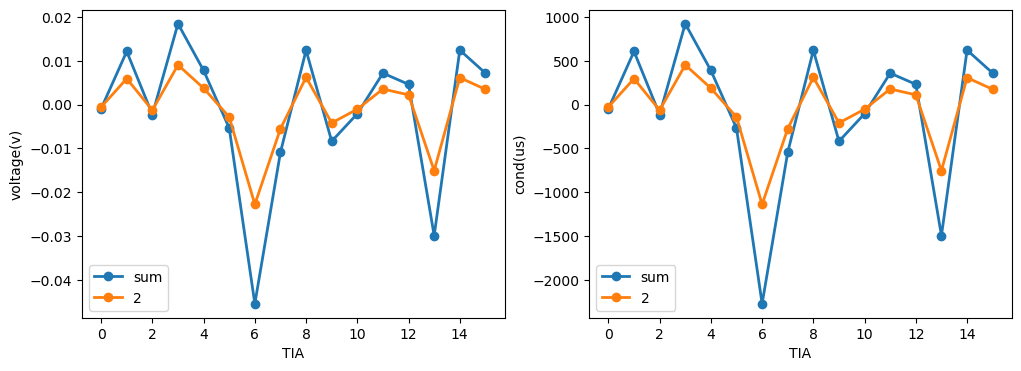

[-0.00091556  0.01216926 -0.00225074  0.01850185  0.00782037 -0.00534074
 -0.04547258 -0.01087222  0.01243629 -0.00835444 -0.00206     0.00721
  0.00465407 -0.02990814  0.01247444  0.00721   ]
[-0.00053407  0.00595111 -0.00125889  0.00907926  0.00377667 -0.00282296
 -0.02277444 -0.00549333  0.00625629 -0.00415815 -0.00103     0.00358592
  0.00225074 -0.01506851  0.00618     0.00350963]


In [11]:
res_sub = [(cond,voltage) for cond,voltage in res]
for cond,voltage in res_sub[:3]:
    # voltage[5]=0
    # cond[5]=0
    # voltage[6]=0
    # cond[6]=0
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(voltage,marker='o', linestyle='-', linewidth=2,label="voltage")
    plt.ylabel("voltage(v)")
    plt.xlabel("TIA")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(cond,marker='o', linestyle='-', linewidth=2,label="cond")
    plt.ylabel("cond(us)")
    plt.xlabel("TIA")

    plt.legend()
    plt.show()


plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(res_sub[0][1]+res_sub[1][1],marker='o', linestyle='-', linewidth=2,label="sum")
plt.plot(res_sub[2][1],marker='o', linestyle='-', linewidth=2,label="2")
plt.ylabel("voltage(v)")
plt.xlabel("TIA")
plt.legend()


plt.subplot(1,2,2)
plt.plot(res_sub[0][0]+res_sub[1][0],marker='o', linestyle='-', linewidth=2,label="sum")
plt.plot(res_sub[2][0],marker='o', linestyle='-', linewidth=2,label="2")
plt.ylabel("cond(us)")
plt.xlabel("TIA")

plt.legend()
plt.show()

print(res_sub[0][1]+res_sub[1][1])
print(res_sub[2][1])

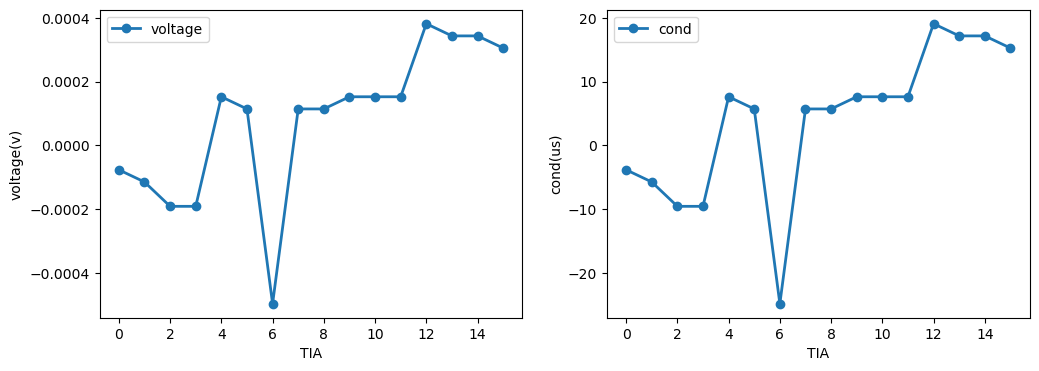

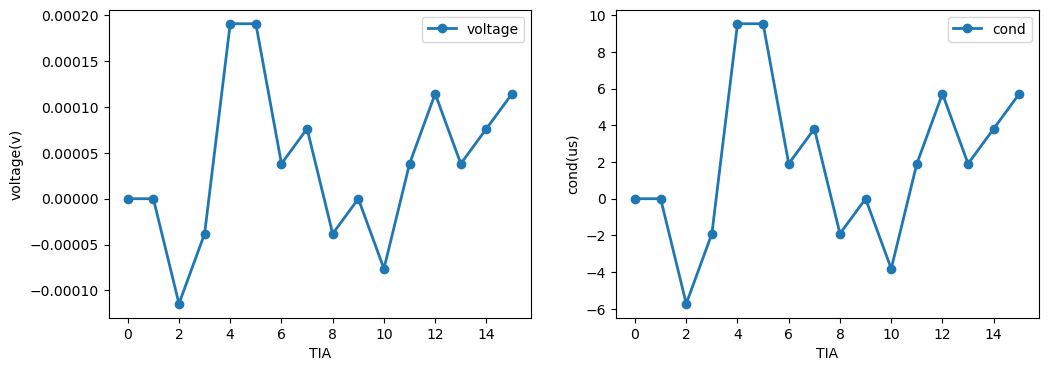

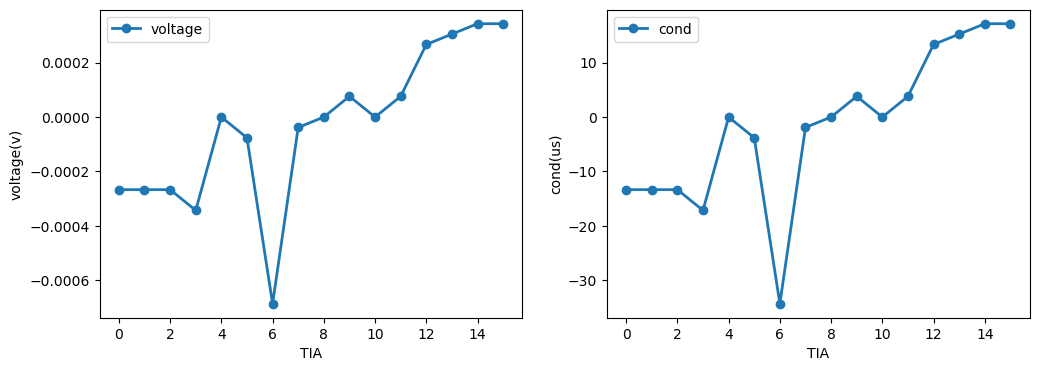

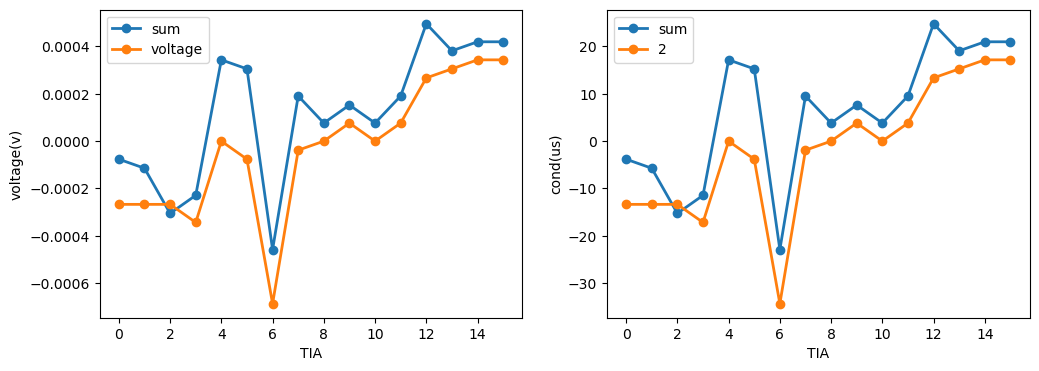

[-7.62962737e-05 -1.14444411e-04 -3.05185095e-04 -2.28888821e-04
  3.43333232e-04  3.05185095e-04 -4.57777642e-04  1.90740684e-04
  7.62962737e-05  1.52592547e-04  7.62962737e-05  1.90740684e-04
  4.95925779e-04  3.81481368e-04  4.19629505e-04  4.19629505e-04]
[-2.67036958e-04 -2.67036958e-04 -2.67036958e-04 -3.43333232e-04
  0.00000000e+00 -7.62962737e-05 -6.86666463e-04 -3.81481368e-05
  0.00000000e+00  7.62962737e-05  0.00000000e+00  7.62962737e-05
  2.67036958e-04  3.05185095e-04  3.43333232e-04  3.43333232e-04]


In [18]:
res_sub = [(cond-cond_base,voltage-voltage_base) for cond,voltage in res]
for cond,voltage in res_sub[3:]:
    # voltage[5]=0
    # cond[5]=0
    # voltage[6]=0
    # cond[6]=0
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(voltage,marker='o', linestyle='-', linewidth=2,label="voltage")
    plt.ylabel("voltage(v)")
    plt.xlabel("TIA")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(cond,marker='o', linestyle='-', linewidth=2,label="cond")
    plt.ylabel("cond(us)")
    plt.xlabel("TIA")

    plt.legend()
    plt.show()


plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(res_sub[3][1]+res_sub[4][1],marker='o', linestyle='-', linewidth=2,label="sum")
plt.plot(res_sub[5][1],marker='o', linestyle='-', linewidth=2,label="voltage")
plt.ylabel("voltage(v)")
plt.xlabel("TIA")
plt.legend()

plt.subplot(1,2,2)
plt.plot(res_sub[3][0]+res_sub[4][0],marker='o', linestyle='-', linewidth=2,label="sum")
plt.plot(res_sub[5][0],marker='o', linestyle='-', linewidth=2,label="2")
plt.ylabel("cond(us)")
plt.xlabel("TIA")

plt.legend()
plt.show()

print(res_sub[3][1]+res_sub[4][1])
print(res_sub[5][1])

### 2.4.2 只开一行，减法读一个器件

In [182]:

chip.set_read_mode(row=True)                # 第二步设置，从行读，还是从列读
chip.set_dac_read_V(0.1)                    # 第三步设置读写电压
chip.set_tia_gain(3)                        # 第四步设置，TIA增益

In [ ]:
chip.set_cim_reset()
chip.set_bank_latch([i for i in range(8)],row=True,value=0xFFFF_FFFF)
chip.set_bank_latch([i for i in range(8)],row=False,value=0xFFFF_FFFF)

In [183]:
res_cond = []
res_voltage = []
read_row=[
    [[181]],
    [[163]],
    [[181,163]]
]
chip.set_cim_reset()
# 
chip.set_bank_latch([i for i in range(8)],row=False,value=0x9999_9999)
for num in read_row:
    chip.set_latch(num,row=True,value=None)

    # 0v读一次
    chip.set_dac_read_V(0)
    chip.generate_read_pulse()
    cond_base,voltage_base = chip.get_tia_out([k for k in range(16)])

    # 0.1v读一次
    chip.set_dac_read_V(0.1)
    chip.generate_read_pulse()
    cond,voltage = chip.get_tia_out([k for k in range(16)])
    res_cond.append(cond-cond_base)
    res_voltage.append(voltage-voltage_base)

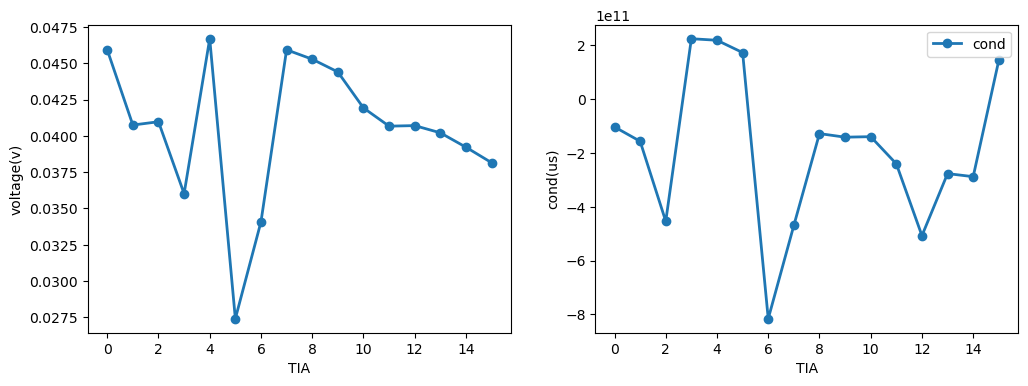

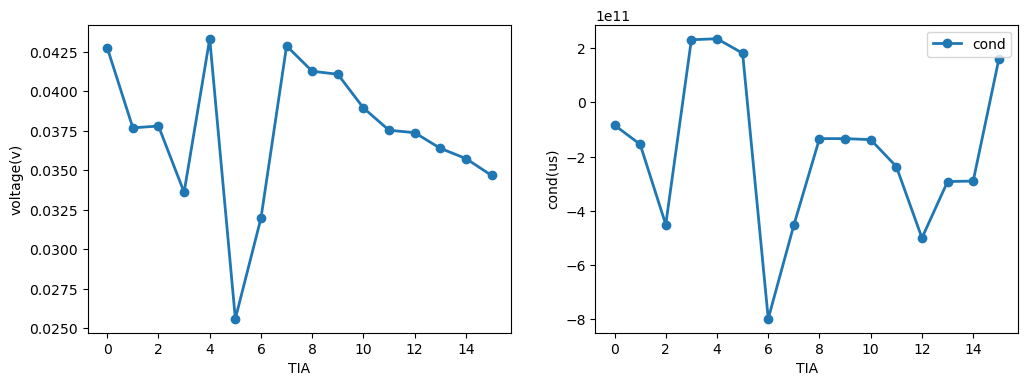

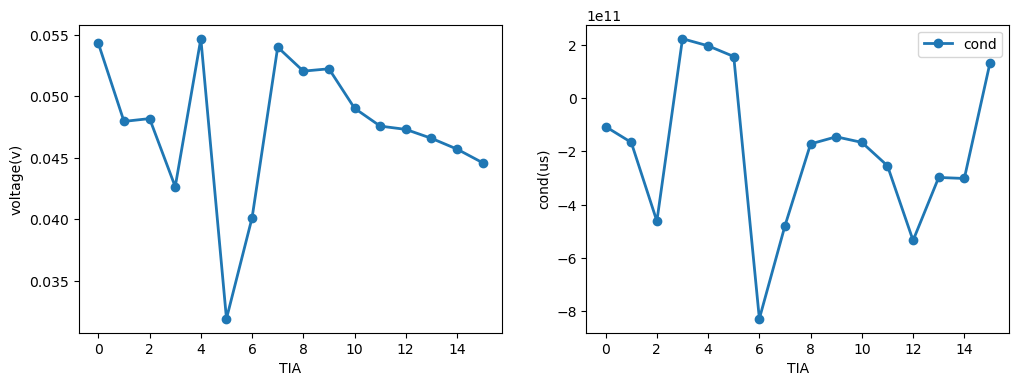

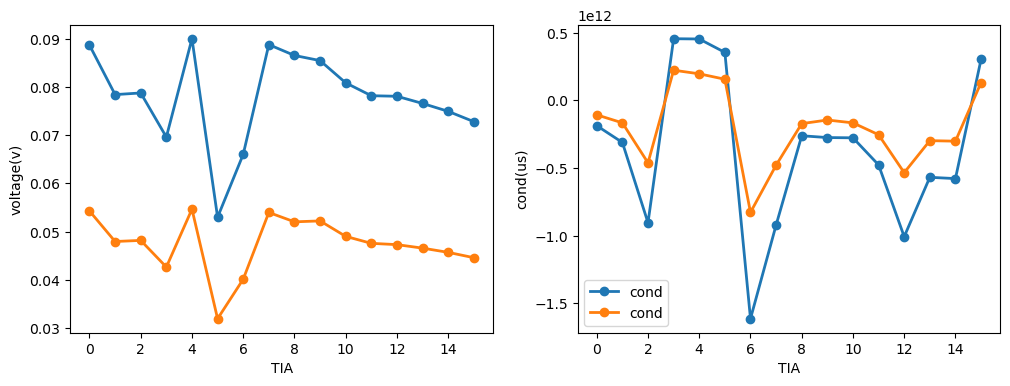

[-1.86925866e+11 -3.10907311e+11 -9.04110838e+11  4.55870238e+11
  4.53962833e+11  3.54777675e+11 -1.61366618e+12 -9.21277499e+11
 -2.61314733e+11 -2.74666581e+11 -2.76573988e+11 -4.76851706e+11
 -1.00711081e+12 -5.68407235e+11 -5.77944269e+11  3.03277691e+11]
[-1.06814780e+11 -1.65944393e+11 -4.61592453e+11  2.23166602e+11
  1.96462907e+11  1.56407363e+11 -8.27814567e+11 -4.78759114e+11
 -1.71666613e+11 -1.44962917e+11 -1.65944393e+11 -2.53685107e+11
 -5.34073913e+11 -2.97555465e+11 -3.01370278e+11  1.31611074e+11]


In [186]:
for k in range(len(res_cond)):
    # voltage[5]=0
    # cond[5]=0
    # voltage[6]=0
    # cond[6]=0
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(res_voltage[k],marker='o', linestyle='-', linewidth=2,label="voltage")
    plt.ylabel("voltage(v)")
    plt.xlabel("TIA")

    plt.subplot(1,2,2)
    plt.plot(res_cond[k],marker='o', linestyle='-', linewidth=2,label="cond")
    plt.ylabel("cond(us)")
    plt.xlabel("TIA")

    plt.legend()
    plt.show()


plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(res_voltage[0]+res_voltage[1],marker='o', linestyle='-', linewidth=2,label="voltage")
plt.plot(res_voltage[2],marker='o', linestyle='-', linewidth=2,label="voltage")
plt.ylabel("voltage(v)")
plt.xlabel("TIA")

plt.subplot(1,2,2)
plt.plot(res_cond[0]+res_cond[1],marker='o', linestyle='-', linewidth=2,label="cond")
plt.plot(res_cond[2],marker='o', linestyle='-', linewidth=2,label="cond")
plt.ylabel("cond(us)")
plt.xlabel("TIA")

plt.legend()
plt.show()

print(res_cond[0]+res_cond[1])
print(res_cond[2])

# 3. 写器件

## 3.1 写读写

In [ ]:

chip.set_read(row=True,v=0.1,gain=3,tg_v=5)

chip.set_cim_reset()
chip.set_bank_latch([i for i in range(8)],row=True,value=0xFFFF_FFFF)
chip.set_bank_latch([i for i in range(8)],row=False,value=0xFFFF_FFFF)

chip.generate_read_pulse()
cond_base,voltage_base = chip.get_tia_out([k for k in range(16)])

chip.generate_write_pulse(pulse_width=1e-6)
chip.generate_read_pulse()
cond_base,voltage_base = chip.get_tia_out([k for k in range(16)])

chip.generate_read_pulse()
cond_base,voltage_base = chip.get_tia_out([k for k in range(16)])

# 4. 测试

## 4.1 测试TIA增益的正确性

In [ ]:

chip.set_read_mode(row=True)                # 第二步设置，从行读，还是从列读
chip.set_dac_read_V(0.1)                    # 第三步设置读写电压
chip.set_tia_gain(3)                        # 第四步设置，TIA增益

### 4.1.1 什么都不接，空读

In [ ]:
for i in range(4):
    print(f"TIA增益为：{i}")
    chip.set_tia_gain(3)                        # 第四步设置，TIA增益
    for j in range(4):
        print(f"第{j}次读。")
        chip.generate_read_pulse()
        cond_base,voltage_base = chip.get_tia_out([k for k in range(16)])
        plot_v_cond(voltage_base,cond_base)

### 4.1.2 行列全接，读电压给0v，TG给5v

In [ ]:
chip.set_cim_reset()
chip.set_bank_latch([i for i in range(8)],row=True,value=0xFFFF_FFFF)
chip.set_bank_latch([i for i in range(8)],row=False,value=0xFFFF_FFFF)

chip.set_dac_read_V(0,tg_v=5)

for i in range(4):
    print(f"TIA增益为：{i}")
    chip.set_tia_gain(3)
    for j in range(4):
        print(f"第{j}次读。")
        chip.generate_read_pulse()
        cond_base,voltage_base = chip.get_tia_out([k for k in range(16)])
        plot_v_cond(voltage_base,cond_base)

### 4.1.3 行列全接，读电压给0v，TG给0v

In [ ]:
chip.set_cim_reset()
chip.set_bank_latch([i for i in range(8)],row=True,value=0xFFFF_FFFF)
chip.set_bank_latch([i for i in range(8)],row=False,value=0xFFFF_FFFF)

chip.set_dac_read_V(0,tg_v=0)

for i in range(4):
    print(f"TIA增益为：{i}")
    chip.set_tia_gain(3)
    for j in range(4):
        print(f"第{j}次读。")
        chip.generate_read_pulse()
        cond_base,voltage_base = chip.get_tia_out([k for k in range(16)])
        plot_v_cond(voltage_base,cond_base)

### 4.1.4 行列全接，读电压给0.1v, TG给5v

In [ ]:
chip.set_cim_reset()
chip.set_bank_latch([i for i in range(8)],row=True,value=0xFFFF_FFFF)
chip.set_bank_latch([i for i in range(8)],row=False,value=0xFFFF_FFFF)

chip.set_dac_read_V(0.1,tg_v=5)

for i in range(4):
    print(f"TIA增益为：{i}")
    chip.set_tia_gain(3)
    for j in range(4):
        print(f"第{j}次读。")
        chip.generate_read_pulse()
        cond_base,voltage_base = chip.get_tia_out([k for k in range(16)])
        plot_v_cond(voltage_base,cond_base)

### 4.1.5 行列全接，读电压给0.2v, TG给5v

In [ ]:
chip.set_cim_reset()
chip.set_bank_latch([i for i in range(8)],row=True,value=0xFFFF_FFFF)
chip.set_bank_latch([i for i in range(8)],row=False,value=0xFFFF_FFFF)

chip.set_dac_read_V(0.2,tg_v=5)

for i in range(4):
    print(f"TIA增益为：{i}")
    chip.set_tia_gain(3)
    for j in range(4):
        print(f"第{j}次读。")
        chip.generate_read_pulse()
        cond_base,voltage_base = chip.get_tia_out([k for k in range(16)])
        plot_v_cond(voltage_base,cond_base)

## 4.2 测试TG的有效性

In [ ]:
chip.set_read_mode(row=True)                # 第二步设置，从行读，还是从列读
chip.set_dac_read_V(0.1)                    # 第三步设置读写电压
chip.set_tia_gain(3)                        # 第四步设置，TIA增益

### 4.2.1 行列全接，读电压给0.1v, TG给0v, gain为3

In [ ]:
chip.set_cim_reset()
chip.set_bank_latch([i for i in range(8)],row=True,value=0xFFFF_FFFF)
chip.set_bank_latch([i for i in range(8)],row=False,value=0xFFFF_FFFF)

chip.set_dac_read_V(0.1,tg_v=0)

for j in range(4):
    print(f"第{j}次读。")
    chip.generate_read_pulse()
    cond_base,voltage_base = chip.get_tia_out([k for k in range(16)])
    plot_v_cond(voltage_base,cond_base)

### 4.2.2 行列全接，读电压给0.1v, TG给5v，gain为3

In [ ]:
chip.set_cim_reset()
chip.set_bank_latch([i for i in range(8)],row=True,value=0xFFFF_FFFF)
chip.set_bank_latch([i for i in range(8)],row=False,value=0xFFFF_FFFF)

chip.set_dac_read_V(0.1,tg_v=5)

for j in range(4):
    print(f"第{j}次读。")
    chip.generate_read_pulse()
    cond_base,voltage_base = chip.get_tia_out([k for k in range(16)])
    plot_v_cond(voltage_base,cond_base)

## 4.3 测试TIA选通的正确性

### 4.3.1 单独选通不同的列，行给电压，列接TIA，读取TIA

In [ ]:
chip.set_read_mode(row=True)                # 第二步设置，从行读，还是从列读
chip.set_dac_read_V(0.1)                    # 第三步设置读写电压
chip.set_tia_gain(3)                        # 第四步设置，TIA增益

In [ ]:
cond0,voltage0 = [],[]
row_num = 19
for i in range(0,256,32):
    #----------------------------------------------------- 第i列
    print(f"第{i+1}列")
    chip.set_cim_reset()
    chip.set_latch([[row_num]],row=True,value=None)
    chip.set_latch([[i]],row=False,value=None)

    # 产生读脉冲
    chip.generate_read_pulse()
    cond,voltage=chip.get_tia_out([i for i in range(16)])

    cond0.append(cond)
    voltage0.append(voltage)
    #----------------------------------------------------- 第i+1列
    print(f"第{i+2}列")
    chip.set_cim_reset()
    chip.set_latch([[row_num]],row=True,value=None)
    chip.set_latch([[i+1]],row=False,value=None)

    # 产生读脉冲
    chip.generate_read_pulse()
    cond,voltage=chip.get_tia_out([i for i in range(16)])

    cond0.append(cond)
    voltage0.append(voltage)

In [ ]:
plt.figure(figsize=(12,8))

plt.subplot(2,1,1)
for i in range(0,16,2):
    plt.plot(voltage0[i], marker='o', linestyle='-', linewidth=2,label=f"col={i*16+1}")
    plt.plot(voltage0[i+1], marker='o', linestyle='-', linewidth=2, markersize=6,label=f"col={i*16+2}")
plt.legend()

plt.subplot(2,1,2)
for i in range(0,16,2):
    plt.plot(cond0[i], marker='o', linestyle='-', linewidth=2,label=f"col={i*16+1}")
    plt.plot(cond0[i+1], marker='o', linestyle='-', linewidth=2, markersize=6,label=f"col={i*16+2}")
plt.legend()

plt.show()

### 4.3.2 单独选通不同的行，列给电压，行接TIA，读取TIA

In [ ]:
chip.set_read_mode(row=False)                # 第二步设置，从行读，还是从列读
chip.set_dac_read_V(0.1)                    # 第三步设置读写电压
chip.set_tia_gain(3)                        # 第四步设置，TIA增益

In [ ]:
cond0,voltage0 = [],[]
row_num = 19
for i in range(0,256,32):
    #----------------------------------------------------- 第i列
    print(f"第{i+1}列")
    chip.set_cim_reset()
    chip.set_latch([[row_num]],row=True,value=None)
    chip.set_latch([[i]],row=False,value=None)

    # 产生读脉冲
    chip.generate_read_pulse()
    cond,voltage=chip.get_tia_out([i for i in range(16)])

    cond0.append(cond)
    voltage0.append(voltage)
    #----------------------------------------------------- 第i+1列
    print(f"第{i+2}列")
    chip.set_cim_reset()
    chip.set_latch([[row_num]],row=True,value=None)
    chip.set_latch([[i+1]],row=False,value=None)

    # 产生读脉冲
    chip.generate_read_pulse()
    cond,voltage=chip.get_tia_out([i for i in range(16)])

    cond0.append(cond)
    voltage0.append(voltage)

In [ ]:
plt.figure(figsize=(12,8))

plt.subplot(2,1,1)
for i in range(0,16,2):
    plt.plot(voltage0[i], marker='o', linestyle='-', linewidth=2,label=f"col={i*16+1}")
    plt.plot(voltage0[i+1], marker='o', linestyle='-', linewidth=2, markersize=6,label=f"col={i*16+2}")
plt.legend()

plt.subplot(2,1,2)
for i in range(0,16,2):
    plt.plot(cond0[i], marker='o', linestyle='-', linewidth=2,label=f"col={i*16+1}")
    plt.plot(cond0[i+1], marker='o', linestyle='-', linewidth=2, markersize=6,label=f"col={i*16+2}")
plt.legend()

plt.show()

## 4.4 测试行列的latch选通的正确

### 4.4.1 行给电压，列读，不断的打开列的latch数量

In [ ]:
chip.set_read_mode(row=True)               # 第二步设置，从行读，还是从列读
chip.set_dac_read_V(0.1)                    # 第三步设置读写电压
chip.set_tia_gain(3)                        # 第四步设置，TIA增益

In [ ]:
banknum = 1
for i in range(banknum):
    tmp = 0
    chip.set_cim_reset()
    chip.set_latch([[0]],row=True,value=None)
    for j in range(32):
        tmp=tmp|(1<<j) 
        chip.set_bank_latch([i],row=False,value=tmp)
        chip.generate_read_pulse()
        cond_base,voltage_base = chip.get_tia_out([k for k in range(16)])
        cond.append(cond_base)
        voltage.append(voltage_base)

In [ ]:
with open('./result/read_data/voltage256_col_RRAM.json', 'w') as f:
    json.dump(voltage, f)

with open('./result/read_data/cond256_col_RRAM.json', 'w') as f:
    json.dump(cond, f)

for i in range(banknum):
    plt.figure(figsize=(16,8))
    for k in range(16):
        plt.subplot(1,2,1)
        plt.ylabel("voltage")
        plt.xlabel("TIA")
        plt.plot(voltage[32*i+k], marker='o',label=f"numOfcol={k}")
        plt.legend()

        plt.subplot(1,2,2)
        plt.ylabel("cond")
        plt.xlabel("TIA")
        plt.plot(cond[32*i+k], marker='o',label=f"numOfcol={k}")
        plt.legend()
    plt.show()

    plt.figure(figsize=(16,8))
    for k in range(16,32):
        plt.subplot(1,2,1)
        plt.ylabel("voltage")
        plt.xlabel("TIA")
        plt.plot(voltage[32*i+k], marker='o',label=f"numOfcol={k}")
        plt.legend()

        plt.subplot(1,2,2)
        plt.ylabel("cond")
        plt.xlabel("TIA")
        plt.plot(cond[32*i+k], marker='o',label=f"numOfcol={k}")
        plt.legend()
    plt.show()

### 4.4.2 行给电压，列读，不断的打开行的latch数量

In [ ]:
chip.set_read_mode(row=True)               # 第二步设置，从行读，还是从列读
chip.set_dac_read_V(0.1)                    # 第三步设置读写电压
chip.set_tia_gain(3)                        # 第四步设置，TIA增益

In [ ]:
banknum = 1
for i in range(banknum):
    tmp = 0
    chip.set_cim_reset()
    chip.set_bank_latch([i for i in range(8)],row=False,value=0xFFFF_FFFF)
    for j in range(32):
        tmp=tmp|(1<<j) 
        chip.set_bank_latch([i],row=True,value=tmp)
        chip.generate_read_pulse()
        cond_base,voltage_base = chip.get_tia_out([k for k in range(16)])
        cond.append(cond_base)
        voltage.append(voltage_base)

In [ ]:
with open('./result/read_data/voltage256_row_RRAM.json', 'w') as f:
    json.dump(voltage, f)

with open('./result/read_data/cond256_row_RRAM.json', 'w') as f:
    json.dump(cond, f)

for i in range(banknum):
    plt.figure(figsize=(16,8))
    for k in range(16):
        plt.subplot(1,2,1)
        plt.ylabel("voltage")
        plt.xlabel("TIA")
        plt.plot(voltage[32*i+k], marker='o',label=f"numOfcol={k}")
        plt.legend()

        plt.subplot(1,2,2)
        plt.ylabel("cond")
        plt.xlabel("TIA")
        plt.plot(cond[32*i+k], marker='o',label=f"numOfcol={k}")
        plt.legend()
    plt.show()

    plt.figure(figsize=(16,8))
    for k in range(16,32):
        plt.subplot(1,2,1)
        plt.ylabel("voltage")
        plt.xlabel("TIA")
        plt.plot(voltage[32*i+k], marker='o',label=f"numOfcol={k}")
        plt.legend()

        plt.subplot(1,2,2)
        plt.ylabel("cond")
        plt.xlabel("TIA")
        plt.plot(cond[32*i+k], marker='o',label=f"numOfcol={k}")
        plt.legend()
    plt.show()

## 4.4 测试reg

In [112]:
chip.set_read_mode(row=True)               # 第二步设置，从行读，还是从列读
chip.set_dac_read_V(0.1)                    # 第三步设置读写电压
chip.set_tia_gain(3)                        # 第四步设置，TIA增益

In [113]:
# NEGTIVE_REG_CLK 为1 ，negative_reg_clk有效，NEGTIVE_REG_CLK 为0 ，cfg_pos_reg_clk有效，

In [114]:
pkts=Packet()

pkts.append_cmdlist([
    CMD(CIM_EN,command_data=CmdData(1)),
],mode=1)   
chip.ps.send_packets(pkts)

In [116]:
num = 0
for k in range(100000000):
    for i in range(8):
        pkts=Packet()
        pkts.append_cmdlist([
            CMD(SER_PARA_SEL,command_data=CmdData(1)),
        ],mode=1)   
        chip.ps.send_packets(pkts)
        chip.set_cim_reset()
        chip.set_bank_latch([0],row=True,value=0xFFFF_FFFF)
        chip.set_bank_latch([i],row=False,value=0x0000_0003)

        chip.generate_read_pulse()
        cond,voltage = chip.get_tia_out([k for k in range(16)])


        tag = True
        print("移位：",end="")
        for j in range(32):
            print(f" {j} ",end="")
            pkts=Packet()
            pkts.append_cmdlist([
                CMD(SER_PARA_SEL,command_data=CmdData(0)),
                CMD(FAST_COMMAND_1,command_data=CmdData(FAST_COMMAND1_CONF.cfg_reg_clk)),           # cfg_reg_clk
                CMD(FAST_COMMAND_1,command_data=CmdData(FAST_COMMAND1_CONF.cfg_latch_clk)),         # cfg_latch_clk
            ],mode=1)   
            chip.ps.send_packets(pkts)
            chip.generate_read_pulse()
            cond_base,voltage_base = chip.get_tia_out([k for k in range(16)])

            for key,value in enumerate(voltage_base):
                if value>voltage[i*2]/2:
                    # 有值的对不对
                    if j<14 and key == i*2:
                        pass
                    elif j>14 and key == (i*2+1):
                        pass
                    elif j==14 and (key == i*2 or key == i*2+1):
                        pass
                    else:
                        print(1111,key,value,voltage[i*2]/2)
                        tag = False
                else:
                    # 没值的对不对
                    if j<14 and key != (i*2):
                        pass
                    elif j>14 and key != (i*2+1):
                        pass
                    elif j==14 and (key != (i*2) and key != (i*2+1)):
                        pass
                    elif j==31:
                        pass
                    else:
                        print(2222,key,value,voltage[i*2]/2)
                        tag = False
            print(f" {tag} ",end="")
        print("")
        if tag:
            num = num+1
        print(f"第{k*8+i}次测试结果：{tag}\t\t,总的准确率：{num/(k+1)}")

KeyboardInterrupt: 

第0位设置为1 [-1.06814783e-03  8.39259011e-04  4.43243202e-01 -6.56147954e-03
 -7.66777551e-03 -5.37888730e-03  1.39240699e-02  5.87481307e-03
 -6.10370190e-04 -7.62962737e-04 -7.62962737e-05  1.67851802e-03
  7.32444227e-03  2.74666585e-03  2.70851772e-03 -6.06555376e-03]


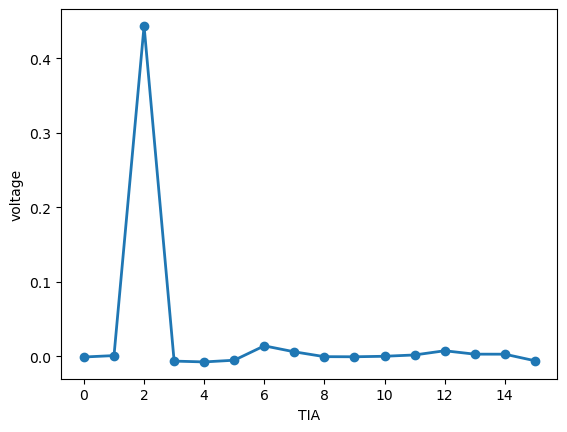

第0次挤出一位 [-9.91851558e-04  9.53703421e-04  4.48316904e-01 -6.48518326e-03
 -8.04925687e-03 -5.76036866e-03  1.36951811e-02  5.60777612e-03
 -7.62962737e-04 -9.53703421e-04 -3.05185095e-04  1.48777734e-03
  7.20999786e-03  2.67036958e-03  2.51777703e-03 -6.10370190e-03]
第1次挤出一位 [-9.91851558e-04  8.01110874e-04  4.51826533e-01 -6.48518326e-03
 -8.27814570e-03 -5.95110935e-03  1.34281442e-02  5.37888730e-03
 -7.62962737e-04 -1.02999969e-03 -3.43333232e-04  1.41148106e-03
  6.98110904e-03  2.44148076e-03  2.32703635e-03 -6.29444258e-03]
第2次挤出一位 [-1.10629597e-03  7.24814600e-04  4.55374310e-01 -6.59962767e-03
 -7.59147923e-03 -5.37888730e-03  1.40003662e-02  6.06555376e-03
 -7.62962737e-04 -9.53703421e-04 -2.28888821e-04  1.52592547e-03
  7.09555345e-03  2.47962889e-03  2.32703635e-03 -6.29444258e-03]
第3次挤出一位 [-1.29703665e-03  6.86666463e-04  4.59456160e-01 -6.67592395e-03
 -8.62147893e-03 -6.21814631e-03  1.32755516e-02  5.07370220e-03
 -8.01110874e-04 -1.02999969e-03 -2.67036958e-04  1.411

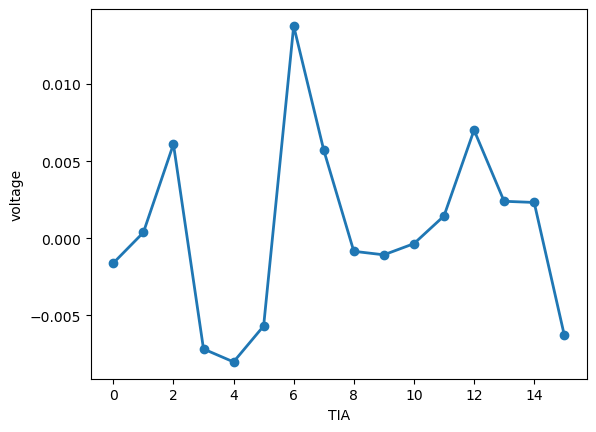

第1位设置为1 [-1.18259224e-03  6.86666463e-04  4.49079867e-01 -6.63777581e-03
 -8.04925687e-03 -5.83666494e-03  1.36570330e-02  5.53147984e-03
 -8.39259011e-04 -1.02999969e-03 -3.05185095e-04  1.48777734e-03
  6.90481277e-03  2.32703635e-03  2.28888821e-03 -6.44703513e-03]


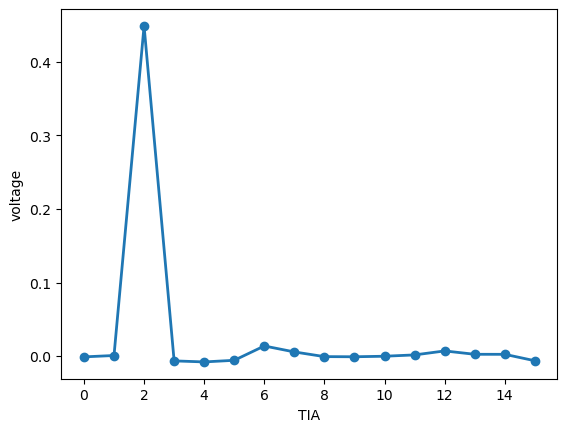

第0次挤出一位 [-9.53703421e-04  9.53703421e-04  4.52818384e-01 -6.40888699e-03
 -7.85851619e-03 -5.79851680e-03  1.37333293e-02  5.64592425e-03
 -6.48518326e-04 -8.39259011e-04 -7.62962737e-05  1.60222175e-03
  7.28629414e-03  2.70851772e-03  2.70851772e-03 -6.02740562e-03]
第1次挤出一位 [-1.29703665e-03  6.10370190e-04  4.56404309e-01 -6.75222022e-03
 -7.74407178e-03 -5.49333171e-03  1.40003662e-02  5.87481307e-03
 -6.86666463e-04 -9.53703421e-04 -2.67036958e-04  1.52592547e-03
  6.82851650e-03  2.32703635e-03  2.28888821e-03 -6.48518326e-03]
第2次挤出一位 [-1.10629597e-03  8.01110874e-04  4.60676901e-01 -6.52333140e-03
 -7.62962737e-03 -5.41703543e-03  1.41529588e-02  6.02740562e-03
 -8.01110874e-04 -9.53703421e-04 -2.67036958e-04  1.48777734e-03
  7.09555345e-03  2.51777703e-03  2.44148076e-03 -6.21814631e-03]
第3次挤出一位 [-1.02999969e-03  8.39259011e-04  4.63347270e-01 -6.37073885e-03
 -7.47703482e-03 -5.37888730e-03  1.41529588e-02  6.06555376e-03
 -5.72222053e-04 -8.39259011e-04 -1.52592547e-04  1.640

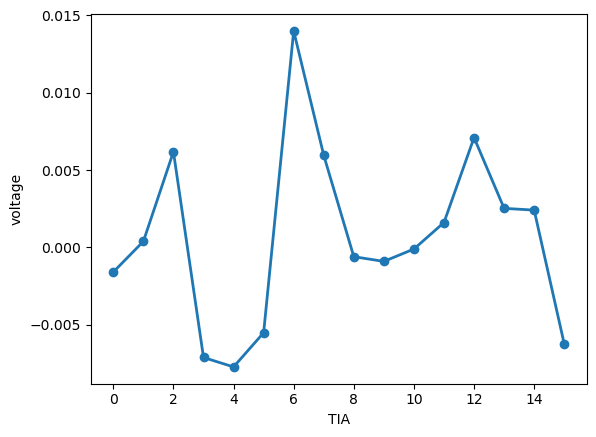

第2位设置为1 [-1.22074038e-03  6.86666463e-04  4.52360607e-01 -6.63777581e-03
 -7.93481246e-03 -5.64592425e-03  1.38096255e-02  5.76036866e-03
 -6.86666463e-04 -9.53703421e-04 -1.90740684e-04  1.52592547e-03
  7.17184973e-03  2.63222144e-03  2.51777703e-03 -6.17999817e-03]


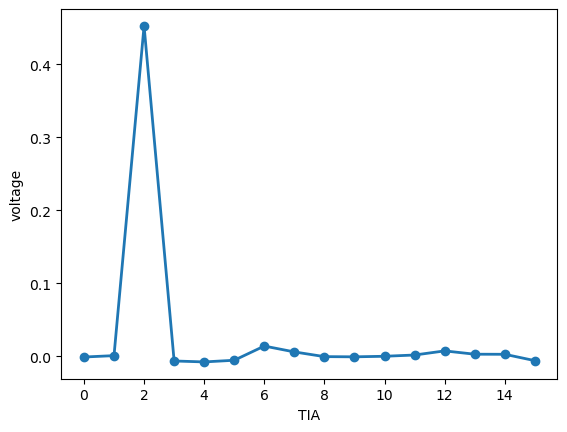

第0次挤出一位 [-1.06814783e-03  8.01110874e-04  4.56518754e-01 -6.52333140e-03
 -7.82036805e-03 -5.60777612e-03  1.39240699e-02  5.79851680e-03
 -5.34073916e-04 -7.62962737e-04 -3.81481368e-05  1.71666616e-03
  7.32444227e-03  2.70851772e-03  2.63222144e-03 -5.98925748e-03]
第1次挤出一位 [-9.15555284e-04  9.91851558e-04  4.60638752e-01 -6.33259072e-03
 -7.43888668e-03 -5.26444288e-03  1.42674032e-02  6.14185003e-03
 -6.48518326e-04 -9.53703421e-04 -1.52592547e-04  1.56407361e-03
  7.24814600e-03  2.67036958e-03  2.51777703e-03 -6.10370190e-03]
第2次挤出一位 [-1.18259224e-03  8.39259011e-04  4.64148381e-01 -6.56147954e-03
 -8.01110874e-03 -5.68407239e-03  1.38859218e-02  5.76036866e-03
 -7.62962737e-04 -1.02999969e-03 -2.28888821e-04  1.52592547e-03
  7.05740532e-03  2.47962889e-03  2.36518448e-03 -6.33259072e-03]
第3次挤出一位 [-1.02999969e-03  7.62962737e-04  4.71205786e-01 -6.56147954e-03
 -8.39259011e-03 -6.14185003e-03  1.33518479e-02  5.30259102e-03
 -6.86666463e-04 -9.53703421e-04 -1.90740684e-04  1.602

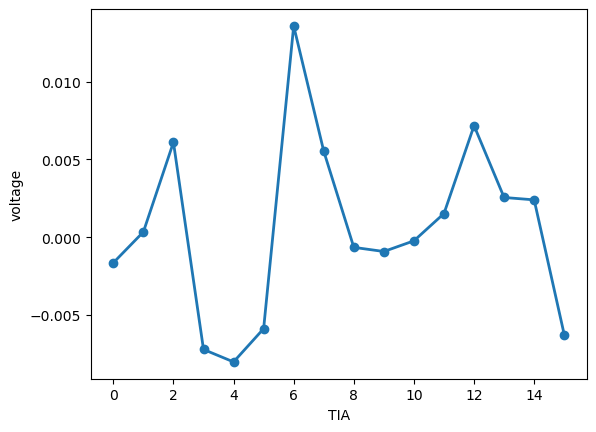

第3位设置为1 [-1.10629597e-03  8.39259011e-04  4.56671346e-01 -6.56147954e-03
 -7.62962737e-03 -5.53147984e-03  1.39622181e-02  5.91296121e-03
 -6.86666463e-04 -8.39259011e-04 -1.90740684e-04  1.64036988e-03
  7.20999786e-03  2.55592517e-03  2.55592517e-03 -6.14185003e-03]


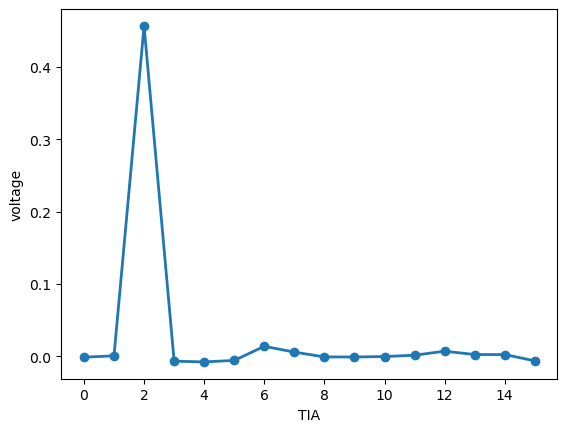

第0次挤出一位 [-8.01110874e-04  1.02999969e-03  4.61973937e-01 -6.33259072e-03
 -8.12555315e-03 -5.87481307e-03  1.33899960e-02  5.37888730e-03
 -8.01110874e-04 -1.02999969e-03 -3.81481368e-04  1.33518479e-03
  6.98110904e-03  2.47962889e-03  2.40333262e-03 -6.21814631e-03]
第1次挤出一位 [-9.91851558e-04  9.15555284e-04  4.63690603e-01 -6.44703513e-03
 -7.55333110e-03 -5.30259102e-03  1.40766625e-02  5.98925748e-03
 -6.10370190e-04 -8.39259011e-04 -1.14444411e-04  1.64036988e-03
  7.20999786e-03  2.70851772e-03  2.47962889e-03 -6.14185003e-03]
第2次挤出一位 [-1.02999969e-03  8.01110874e-04  4.71816156e-01 -6.48518326e-03
 -7.51518296e-03 -5.34073916e-03  1.40766625e-02  6.14185003e-03
 -6.86666463e-04 -9.53703421e-04 -2.67036958e-04  1.48777734e-03
  7.17184973e-03  2.59407331e-03  2.47962889e-03 -6.21814631e-03]
第3次挤出一位 [-1.06814783e-03  8.39259011e-04  4.71396527e-01 -6.52333140e-03
 -8.12555315e-03 -5.87481307e-03  1.35425886e-02  5.45518357e-03
 -7.24814600e-04 -9.91851558e-04 -3.05185095e-04  1.487

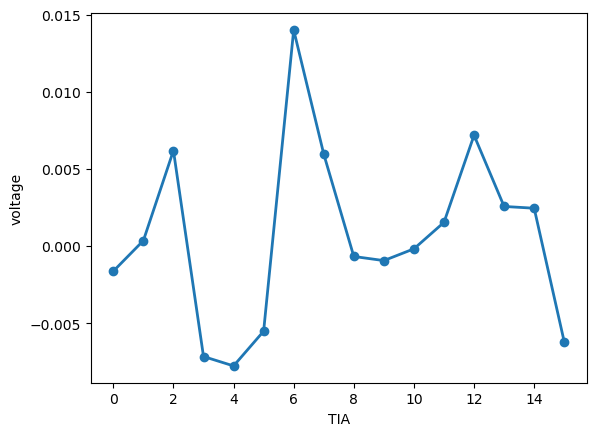

第4位设置为1 [-9.91851558e-04  8.77407147e-04  4.64529862e-01 -6.44703513e-03
 -7.55333110e-03 -5.30259102e-03  1.41911069e-02  6.10370190e-03
 -6.86666463e-04 -9.15555284e-04 -1.52592547e-04  1.56407361e-03
  7.24814600e-03  2.70851772e-03  2.55592517e-03 -6.21814631e-03]


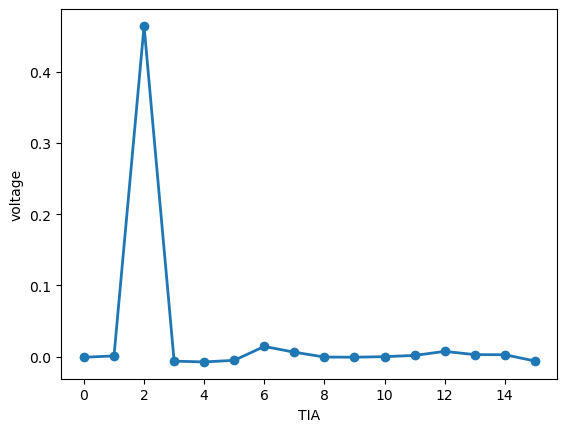

第0次挤出一位 [-0.0009537   0.0009537   0.46754357 -0.00648518 -0.00766778 -0.00545518
  0.01407666  0.00595111 -0.00053407 -0.00076296  0.          0.00164037
  0.0071337   0.00255593  0.00247963 -0.00621815]
第1次挤出一位 [-8.77407147e-04  9.15555284e-04  4.74562822e-01 -6.29444258e-03
 -7.66777551e-03 -5.41703543e-03  1.40766625e-02  6.02740562e-03
 -6.10370190e-04 -8.39259011e-04 -1.52592547e-04  1.60222175e-03
  7.17184973e-03  2.59407331e-03  2.47962889e-03 -6.17999817e-03]
第2次挤出一位 [-1.06814783e-03  8.01110874e-04  4.74486526e-01 -6.48518326e-03
 -7.78221992e-03 -5.53147984e-03  1.39622181e-02  5.87481307e-03
 -7.62962737e-04 -9.91851558e-04 -2.28888821e-04  1.44962920e-03
  7.28629414e-03  2.63222144e-03  2.55592517e-03 -6.17999817e-03]
第3次挤出一位 [-1.10629597e-03  7.62962737e-04  4.71320231e-01 -6.59962767e-03
 -7.85851619e-03 -5.60777612e-03  1.38477737e-02  5.76036866e-03
 -6.86666463e-04 -9.53703421e-04 -2.28888821e-04  1.64036988e-03
  6.90481277e-03  2.36518448e-03  2.17444380e-03 -6.408

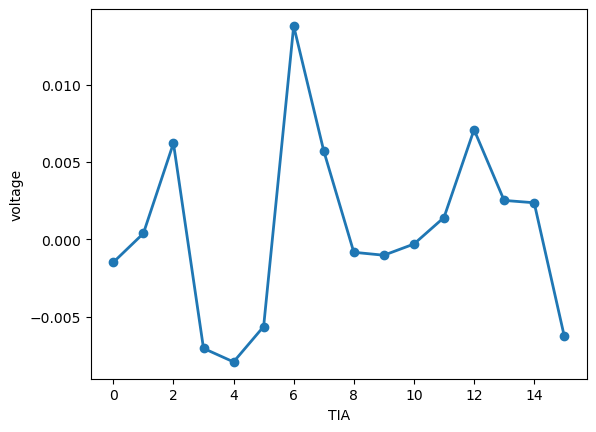

第5位设置为1 [-9.91851558e-04  9.15555284e-04  4.65483566e-01 -6.48518326e-03
 -7.89666433e-03 -5.68407239e-03  1.37714774e-02  5.76036866e-03
 -6.10370190e-04 -8.77407147e-04 -1.52592547e-04  1.60222175e-03
  7.20999786e-03  2.63222144e-03  2.55592517e-03 -6.14185003e-03]


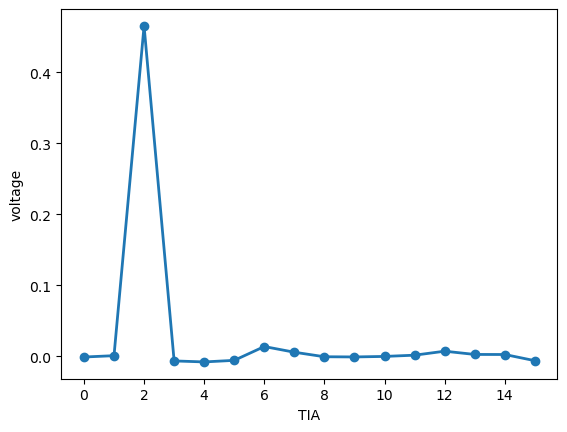

第0次挤出一位 [-9.91851558e-04  8.77407147e-04  4.72960601e-01 -6.40888699e-03
 -7.66777551e-03 -5.37888730e-03  1.40766625e-02  6.02740562e-03
 -6.48518326e-04 -8.39259011e-04 -1.14444411e-04  1.56407361e-03
  6.86666463e-03  2.32703635e-03  2.21259194e-03 -6.40888699e-03]
第1次挤出一位 [-1.02999969e-03  8.01110874e-04  4.72846156e-01 -6.48518326e-03
 -8.04925687e-03 -5.79851680e-03  1.37333293e-02  5.56962798e-03
 -7.62962737e-04 -1.06814783e-03 -3.43333232e-04  1.44962920e-03
  7.09555345e-03  2.47962889e-03  2.44148076e-03 -6.25629444e-03]
第2次挤出一位 [-1.02999969e-03  8.77407147e-04  4.69946898e-01 -6.44703513e-03
 -7.85851619e-03 -5.68407239e-03  1.38096255e-02  5.76036866e-03
 -7.62962737e-04 -1.10629597e-03 -3.05185095e-04  1.41148106e-03
  7.17184973e-03  2.55592517e-03  2.47962889e-03 -6.25629444e-03]
第3次挤出一位 [-1.18259224e-03  6.86666463e-04  4.64262825e-01 -6.59962767e-03
 -8.01110874e-03 -5.72222053e-03  1.38096255e-02  5.64592425e-03
 -7.24814600e-04 -9.15555284e-04 -1.90740684e-04  1.564

KeyboardInterrupt: 

In [83]:
for i in range(32):
    pkts=Packet()
    pkts.append_cmdlist([
        CMD(SER_PARA_SEL,command_data=CmdData(1)),
    ],mode=1)   
    chip.ps.send_packets(pkts)
    chip.set_cim_reset()
    chip.set_bank_latch([0],row=True,value=0xFFFF_FFFF)
    chip.set_bank_latch([1],row=False,value=1<<i)

    chip.generate_read_pulse()
    cond_base,voltage_base = chip.get_tia_out([k for k in range(16)])

    print(f"第{i}位设置为1",voltage_base)
    plt.figure()
    plt.plot(voltage_base, marker='o', linestyle='-', linewidth=2)
    plt.ylabel("voltage")
    plt.xlabel("TIA")
    plt.show()

    for j in range(32-i):
        pkts=Packet()
        pkts.append_cmdlist([
            CMD(SER_PARA_SEL,command_data=CmdData(0)),
            CMD(FAST_COMMAND_1,command_data=CmdData(FAST_COMMAND1_CONF.cfg_reg_clk)),           # cfg_reg_clk
            CMD(FAST_COMMAND_1,command_data=CmdData(FAST_COMMAND1_CONF.cfg_latch_clk)),         # cfg_latch_clk
        ],mode=1)   
        chip.ps.send_packets(pkts)
        chip.generate_read_pulse()
        cond_base,voltage_base = chip.get_tia_out([k for k in range(16)])
        print(f"第{j}次挤出一位",voltage_base)
    
    plt.figure()
    plt.plot(voltage_base, marker='o', linestyle='-', linewidth=2)
    plt.ylabel("voltage")
    plt.xlabel("TIA")
    plt.show()

In [17]:
pkts=Packet()

pkts.append_cmdlist([
    # 行reg配置
    # CMD(CIM_DATA_IN,command_data=CmdData(0b1010_1010_1010_1010_1010_1010_1010_1010)),                                       # 第index位置1
    CMD(CIM_DATA_IN,command_data=CmdData(0xFFFF_FFFF)),                                       # 第index位置1
    CMD(FAST_COMMAND_1,command_data=CmdData(FAST_COMMAND1_CONF.cfg_cim_data_in)),       # cfg_cim_data_in
    CMD(FAST_COMMAND_1,command_data=CmdData(FAST_COMMAND1_CONF.cfg_reg_clk)),           # cfg_reg_clk
    # CMD(FAST_COMMAND_1,command_data=CmdData(FAST_COMMAND1_CONF.negative_reg_clk)),     # negative_reg_clk
    # CMD(FAST_COMMAND_1,command_data=CmdData(FAST_COMMAND1_CONF.cfg_pos_reg_clk)),      # negative_reg_clk
],mode=1)   
chip.ps.send_packets(pkts)

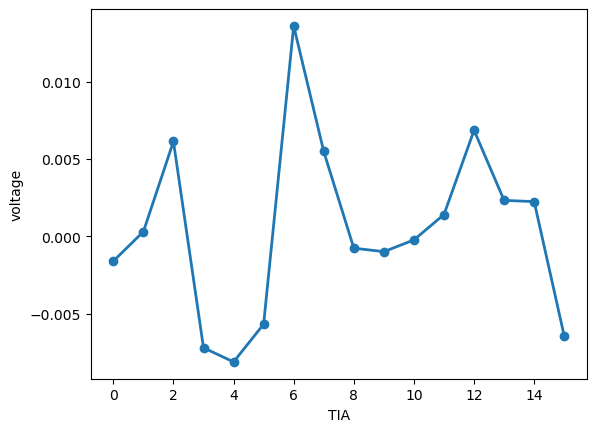

In [82]:
# pkts=Packet()
# pkts.append_cmdlist([
#     CMD(SER_PARA_SEL,command_data=CmdData(1)),
# ],mode=1)   
# chip.ps.send_packets(pkts)
# chip.set_cim_reset()
# chip.set_bank_latch([0],row=True,value=0xFFFF_FFFF)
# chip.set_bank_latch([1],row=False,value=0x8000_0000)

chip.generate_read_pulse()
cond_base,voltage_base = chip.get_tia_out([k for k in range(16)])

plt.figure()
plt.plot(voltage_base, marker='o', linestyle='-', linewidth=2)
plt.ylabel("voltage")
plt.xlabel("TIA")
plt.show()

In [21]:
pkts=Packet()

pkts.append_cmdlist([
    CMD(CIM_EN,command_data=CmdData(1)),
],mode=1)   
chip.ps.send_packets(pkts)

In [81]:
pkts=Packet()

pkts.append_cmdlist([
    CMD(SER_PARA_SEL,command_data=CmdData(0)),
    CMD(FAST_COMMAND_1,command_data=CmdData(FAST_COMMAND1_CONF.cfg_reg_clk)),           # cfg_reg_clk
    CMD(FAST_COMMAND_1,command_data=CmdData(FAST_COMMAND1_CONF.cfg_latch_clk)),         # cfg_latch_clk
],mode=1)   
chip.ps.send_packets(pkts)